----
# Wnt Heterogeneity in Medulloblastoma Cell Lines (NO SHH)
L.Richards  
July 2018  

---
 
**Collaborators:** David Bakhshinyan & Dr. Sheila Singh  
**Data Dir:** /mnt/work1/users/pughlab/data/180531_D00165_0204_ACCJ7PANXX_Singh_David/  

In [57]:
suppressMessages(library(dropbead))
suppressMessages(library(Seurat))
suppressMessages(library(scater))
suppressMessages(library(scran))
suppressMessages(library(scater))

Warning message:
“package ‘Seurat’ was built under R version 3.4.4”Warning message:
“package ‘cowplot’ was built under R version 3.4.3”Warning message:
“package ‘Matrix’ was built under R version 3.4.4”

----
# 1.0 Overview
----

**Research Objective:**  
Singh Lab would like to investigte heterogeneity of Wnt pathway activation in a cohort of patient-derived medulloblastoma cell lines at single cell resolution.   

**Sample Processing:**  
[David to provide blurb about sample processing upstream of 10X Genomics capture, were the samples fresh, frozen, dissociated etc?]  

**CellRanger:**  
[PMGC/Zhibin to provide blurb about how library prep, sequencing, and running CellRanger]  

---

**Table 1.** Outline of seqeuncing QC metrics from individual 10x runs. Libraries are not normalized for depth in any way. This info is taken from summary html file output from CellRanger and offers only a preliminary look at the data; several of these numbers will change after depth normalization and QC. 

|Sample ID|Subgroup|Tumour Stage|Matrix Flag|Number of Cells|
|---|---|
|BT853|WNT|Primary|
|HD-MB03|GR_3|Primary|
|MB002|GR_3|Recurrent|
|BT948|GR_4|Primary|
|ICB1299|GR_4|Primary|

---
# 3.0 Library Depth Normalization
---

### Need to redo because BT992 is removed from the data set

The six libraries were sequenced to very different depths (Table 1). To make gene expression libraries across the 6 samples comparable, we must downsample the number of reads in each library to an equal depth. To do this, we use the [CellRanger "aggregate" function](https://support.10xgenomics.com/single-cell-gene-expression/software/pipelines/latest/using/aggregate). In brief, reads are subsampled from higher-depth libraries until there is an equal number of confidently mapped reads per cell across all libraries. Since we did not use the default CellRanger algortihm to determine cell number, we need to subset the resultant down-sampled expression matrix with the list of barcodes determined previously. This will be the expression matrix used for all downstream analysis. 

In [43]:
#write out the list of "true cell barcodes" as determined by Dropbead

file.path <- '~/Desktop/Samwise/data/180531_D00165_0204_ACCJ7PANXX_Singh_David/aggr_noSHH/readcounts/'
files <- list.files(file.path)
print(files)

[1] "BT853.cell.readcounts.txt.gz"   "BT948.cell.readcounts.txt.gz"  
[3] "HDMB03.cell.readcounts.txt.gz"  "ICB1299.cell.readcounts.txt.gz"
[5] "MB002.cell.readcounts.txt.gz"  


In [44]:
counts <- c(1159, 714, 855, 699, 756)

for (i in 1:length(files)){
    
    reads <- read.table(paste(file.path, files[i], sep = ""))
    
    colnames(reads) <- c("Num.Reads", "Cell.Barcode")
    dim(reads)

    print(paste("Number of cells is", counts[i]))
    cellBCs <- reads[c(1:counts[i]), ]
    dim(cellBCs)
    
    
    file.name <- paste(gsub(".cell.readcounts.txt.gz", "", files[i]), "_readcounts.txt", sep ="")
    print(file.name)
    
    write.table(cellBCs, file.name, sep = "\t", quote = F, col.names = T, row.names = F)
   
}

[1] "Number of cells is 1159"
[1] "BT853_readcounts.txt"
[1] "Number of cells is 714"
[1] "BT948_readcounts.txt"
[1] "Number of cells is 855"
[1] "HDMB03_readcounts.txt"
[1] "Number of cells is 699"
[1] "ICB1299_readcounts.txt"
[1] "Number of cells is 756"
[1] "MB002_readcounts.txt"


---
# 3.0 Subset data frame
---

In [4]:
suppressMessages(library(Seurat))
#subset the matrix and write out DGE
# WIP when the stupid aggr function decides to run -_-

dat <- Read10X("~/Desktop/Samwise/data/180531_D00165_0204_ACCJ7PANXX_Singh_David/aggr_noSHH/aggr_mapped2/outs/raw_gene_bc_matrices_mex/GRCh38/")
dim(dat)

[1]   33694 3686400

In [45]:
#read in cell barcodes from Dropbead and make this the meta.data for Seurat

file.path <- "~/Desktop/Samwise/data/180531_D00165_0204_ACCJ7PANXX_Singh_David/aggr_noSHH/readcounts/"
files <- list.files(file.path, pattern = "_readcounts.txt")
samples <- gsub("_readcounts.txt", "", files)
subgroup <-  c("WNT", "GR_4", "GR_3", "GR_4", "GR_3")
stage <- c("Primary", "Primary", "Primary", "Primary", "Recurrent")

In [46]:
files

[1] "BT853_readcounts.txt"   "BT948_readcounts.txt"   "HDMB03_readcounts.txt" 
[4] "ICB1299_readcounts.txt" "MB002_readcounts.txt"

In [47]:
i <- 1
print(files[i])
print(samples[i])

cells <- read.table(paste(file.path, files[i], sep = ""),
                   header = T)
cells$Sample <- samples[i]
cells$Subgroup <- subgroup[i]
cells$Stage <- stage[i]

print(dim(cells))
print(i)

new.flag <- paste("-", i, sep = "")
cells$Cell.Barcode <- gsub("-1", new.flag, cells$Cell.Barcode)
#head(cells)

for (i in 2:length(files)){
    
    print(files[i])
    print(samples[i])
    
    CBs <- read.table(paste(file.path, files[i], sep = ""),
                   header = T)
    CBs$Sample <- samples[i]
    CBs$Subgroup <- subgroup[i]
    CBs$Stage <- stage[i]
    
    print(dim(CBs))
    print(i)
    new.flag <- paste("-", i, sep = "")
    CBs$Cell.Barcode <- gsub("-1", new.flag, CBs$Cell.Barcode)    
    cells <- rbind(cells, CBs)
}

[1] "BT853_readcounts.txt"
[1] "BT853"
[1] 1159    5
[1] 1
[1] "BT948_readcounts.txt"
[1] "BT948"
[1] 714   5
[1] 2
[1] "HDMB03_readcounts.txt"
[1] "HDMB03"
[1] 855   5
[1] 3
[1] "ICB1299_readcounts.txt"
[1] "ICB1299"
[1] 699   5
[1] 4
[1] "MB002_readcounts.txt"
[1] "MB002"
[1] 756   5
[1] 5


In [ ]:
#### Order of samples
#### BT853 .1 
#### BT948 .2 count = 
#### HDMB03 .3 
#### ICB1299 .4
#### MB002 .5

In [48]:
rownames(cells) <- cells$Cell.Barcode
cells$Cell.Barcode <- NULL
head(cells)

write.table(cells,
           file = '~/Desktop/SinghWnt_June2018/SHH_REMOVED/data/metadata_aggregate.txt',
           quote = F,
           col.names = T,
           row.names = T,
           sep = "\t")

,Num.Reads,Sample,Subgroup,Stage
TGGCGCACAGGGTTAG-1,128546,BT853,WNT,Primary
GCGAGAATCGAGAACG-1,118404,BT853,WNT,Primary
CGCTATCCATGTCCTC-1,114133,BT853,WNT,Primary
CGCTGGAAGGGTCGAT-1,105224,BT853,WNT,Primary
TTAGGACAGGTCGGAT-1,100363,BT853,WNT,Primary
TTCTCAAAGTGGGTTG-1,99285,BT853,WNT,Primary


In [49]:
#subet the downsampled matrix by the rownames aka cells determined by Dropbead

dim(dat) #this is all the barcodes across all libraries post-downsampling

filtered.dat <- dat[ , colnames(dat) %in% rownames(cells)] #keep only columns that are legitimate cells
dim(filtered.dat)

[1]   33694 3686400

[1] 33694  4183

In [50]:
#write out the new DGE, this corresponds to raw counts post-downsampling
#only barcodes identified as true cells by Dropbead are included in the matrix

write.table(as.matrix(filtered.dat),
           file = '~/Desktop/SinghWnt_June2018/SHH_REMOVED/data/Dropbead_rawCounts_aggregate.txt',
           quote = F,
           col.names = T,
           row.names = T,
           sep = "\t")

---
# 2.0 Quality Control
---

Low-quality cells need to be removed to ensure that technical effects do not distort downstream analysis results. Two common measures of cell quality are the library size and the number of expressed features in each library. The library size is defined as the total sum of counts across all features, i.e., genes and spike-in transcripts. Cells with relatively small library sizes are considered to be of low quality as the RNA has not been efficiently captured (i.e., converted into cDNA and amplified) during library preparation. The number of expressed features in each cell is defined as the number of features with non-zero counts for that cell. Any cell with very few expressed genes is likely to be of poor quality as the diverse transcript population has not been successfully captured. The distributions of both of these metrics are shown in Figure 2.

**References:**  
>[A step-by-step workflow for low-level analysis of single-cell RNA-seq data (Lun et al., 2016)](https://f1000research.com/articles/5-2122/v1)  


**Figure 2.** Violoin plots highlighting distribution (density) of different QC metrics. Cells with high mitochondrial content are predicted to be "pooq quality" cells - rationalized that damaged cells "leak" out cytoplasmic mRNA resulting in a higher concentration of mtRNA (skews ratio) compared to healthy, high quality cells. rRNA is a classic quality metric for bulk RNA-seq data. Cell lines (treatment and vehicle) appear very similar to eachother, while there are distinct differences between the cell lines. For example, BT89 T/V has much higher mitochondrial content compared to BT67 T/V. Note these plots use the depth normalized data. 

---
## 2.1 Data wrangling
---


In [51]:
suppressMessages(library(Seurat))

In [52]:
filtered.dat <- read.table('~/Desktop/SinghWnt_June2018/SHH_REMOVED/data/Dropbead_rawCounts_aggregate.txt', header = T)
dim(filtered.dat) 
meta <- read.table('~/Desktop/SinghWnt_June2018/SHH_REMOVED/data/metadata_aggregate.txt', header = T)
dim(meta)

[1] 33694  4183

[1] 4183    4

In [54]:
#replace the - with a .
colnames(filtered.dat)[1:20]
#rownames(meta) <- gsub("-", ".", rownames(meta))
head(rownames(meta))

[1] "AAACCTGAGTCAATAG-1" "AAACCTGGTCATTAGC-1" "AAACCTGTCATTATCC-1"
 [4] "AAACCTGTCTTACCGC-1" "AAACGGGGTCACCCAG-1" "AAACGGGGTCTAGCGC-1"
 [7] "AAACGGGTCCGCATCT-1" "AAAGATGAGGTGTGGT-1" "AAAGATGCATACCATG-1"
[10] "AAAGATGCATGTCTCC-1" "AAAGATGGTCTAGGTT-1" "AAAGCAACAAATTGCC-1"
[13] "AAAGCAATCACGAAGG-1" "AAAGCAATCTCTGCTG-1" "AAAGTAGAGATCCTGT-1"
[16] "AAAGTAGAGCCGGTAA-1" "AAAGTAGCATACAGCT-1" "AAATGCCAGCGTCAAG-1"
[19] "AAATGCCCATCGATGT-1" "AAATGCCCATGAAGTA-1"

[1] "TGGCGCACAGGGTTAG-1" "GCGAGAATCGAGAACG-1" "CGCTATCCATGTCCTC-1"
[4] "CGCTGGAAGGGTCGAT-1" "TTAGGACAGGTCGGAT-1" "TTCTCAAAGTGGGTTG-1"

In [55]:
#initialize a Seurat object
#this will perform some upfront QC on the object
#a gene must be expressed in at least 7 cells across the entire data set which corresponds to 
#about 1% of the smallest number of cells for a given library (1% of 699 = 6.99...round up to 7)

Wnt_medullo <- CreateSeuratObject(raw.data = filtered.dat, 
                                  min.cells = 7, 
                                  min.genes = 0, 
                                  project = "Singh")

In [56]:
#calculate percentage mitochondrial genes

mito.genes <- grep(pattern = "^MT-", 
                   x = rownames(x = Wnt_medullo@data), 
                   value = TRUE)

percent.mito <- Matrix::colSums(Wnt_medullo@raw.data[mito.genes, ])/Matrix::colSums(Wnt_medullo@raw.data)

In [57]:
Wnt_medullo <- AddMetaData(object = Wnt_medullo, 
                          metadata = percent.mito, 
                          col.name = "percent.mito")

Wnt_medullo <- AddMetaData(object = Wnt_medullo, 
                          metadata = meta)

#head(Wnt_medullo@meta.data)
#dim(Wnt_medullo@meta.data)

In [58]:
head(Wnt_medullo@meta.data)
table(Wnt_medullo@meta.data$Sample)
dim(Wnt_medullo@meta.data)

,nGene,nUMI,orig.ident,percent.mito,Num.Reads,Sample,Subgroup,Stage
AAACCTGAGTCAATAG-1,4784,29465,Singh,0.049689441,57223,BT853,WNT,Primary
AAACCTGGTCATTAGC-1,4068,18474,Singh,0.004493774,35775,BT853,WNT,Primary
AAACCTGTCATTATCC-1,706,1535,Singh,0.001955671,9672,BT853,WNT,Primary
AAACCTGTCTTACCGC-1,2001,5328,Singh,0.235779989,15362,BT853,WNT,Primary
AAACGGGGTCACCCAG-1,5208,27359,Singh,0.040176939,49766,BT853,WNT,Primary
AAACGGGGTCTAGCGC-1,2873,7758,Singh,0.140294269,39238,BT853,WNT,Primary



  BT853   BT948  HDMB03 ICB1299   MB002 
   1159     714     855     699     756 

[1] 4183    8

In [59]:
write.table(Wnt_medullo@meta.data,
           file = '~/Desktop/SinghWnt_June2018/SHH_REMOVED/data/metadata_aggregate.txt',
           quote = F,
           col.names = T,
           row.names = T,
           sep = "\t")

---
## 2.2 Plot QC metric distributions
---


In [65]:
meta <- read.table('~/Desktop/SinghWnt_June2018/SHH_REMOVED/data/metadata_aggregate.txt', header = T)
#head(meta)

In [66]:
setwd("~/Desktop/SinghWnt_June2018/SHH_REMOVED/figures/")

In [67]:
#Plot QC metrics

#par(mfrow=c(2,2))
pdf("FigureS4_Mt.pdf")

boxplot(percent.mito~Sample,
        data=meta,
        notch = F,
        ylab = "Percentage Mitochondrial Transcripts",
        las = 2,
        outcex= 0.6
)
abline(h=0.3, lty = 2, col = "red")

boxplot(percent.mito~Stage,
        data=meta,
        notch = F,
        ylab = "Percentage Mitochondrial Transcripts",
        las = 2,
        outcex= 0.6
)
abline(h=0.3, lty = 2, col = "red")

boxplot(percent.mito~Subgroup,
        data=meta,
        notch = F,
        ylab = "Percentage Mitochondrial Transcripts",
        las = 2,
        outcex= 0.6
)
abline(h=0.3, lty = 2, col = "red")

dev.off()

pdf 
  2

In [68]:
pdf("FigureS4_nGene.pdf")

boxplot(nGene~Sample,
        data=meta,
        notch = F,
        ylab = "Number of Genes",
        las = 2,
        outcex= 0.6
)

boxplot(nGene~Stage,
        data=meta,
        notch = F,
        ylab = "Number of Genes",
        las = 2,
        outcex= 0.6
)

boxplot(nGene~Subgroup,
        data=meta,
        notch = F,
        ylab = "Number of Genes",
        las = 2,
        outcex= 0.6
)

dev.off()

pdf 
  2

In [69]:
pdf("FigureS4_nUMI.pdf")
options(scipen=999)
boxplot(nUMI~Sample,
        data=meta,
        notch = F,
        ylab = "Number of Transcripts",
        las = 2,
        outcex= 0.6
)

boxplot(nGene~Stage,
        data=meta,
        notch = F,
        ylab = "Number of Transcripts",
        las = 2,
        outcex= 0.6
)

boxplot(nGene~Subgroup,
        data=meta,
        notch = F,
        ylab = "Number of Transcripts",
        las = 2,
        outcex= 0.6
)

dev.off()

pdf 
  2

[1] 13667.0 15432.5 17891.0 11174.0 10608.5

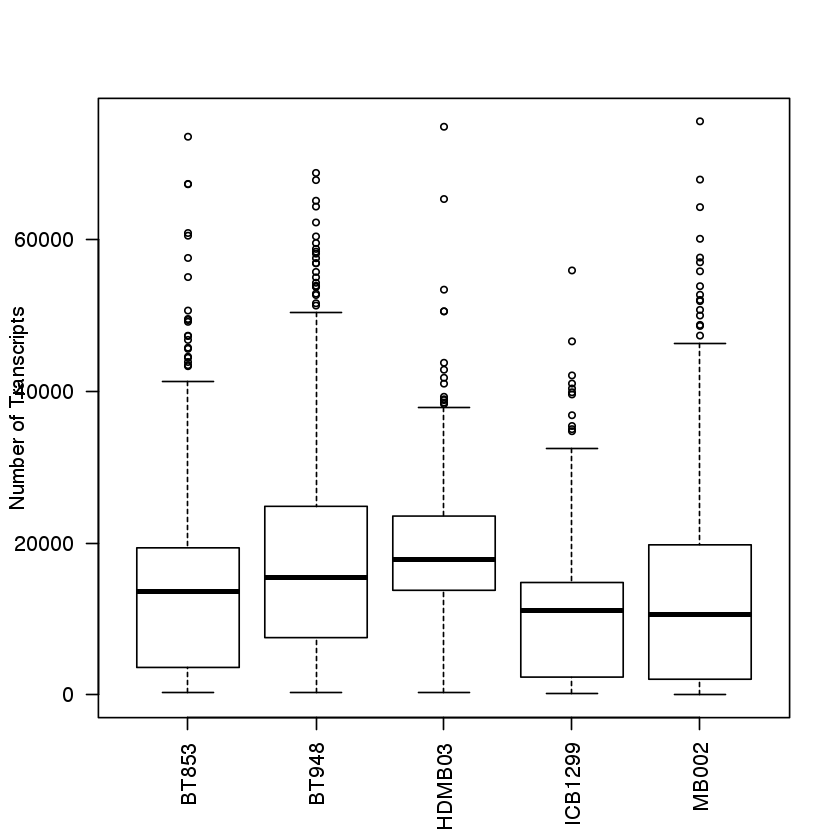

[1] 3607.0 3353.5 3141.0 2616.0 2291.5

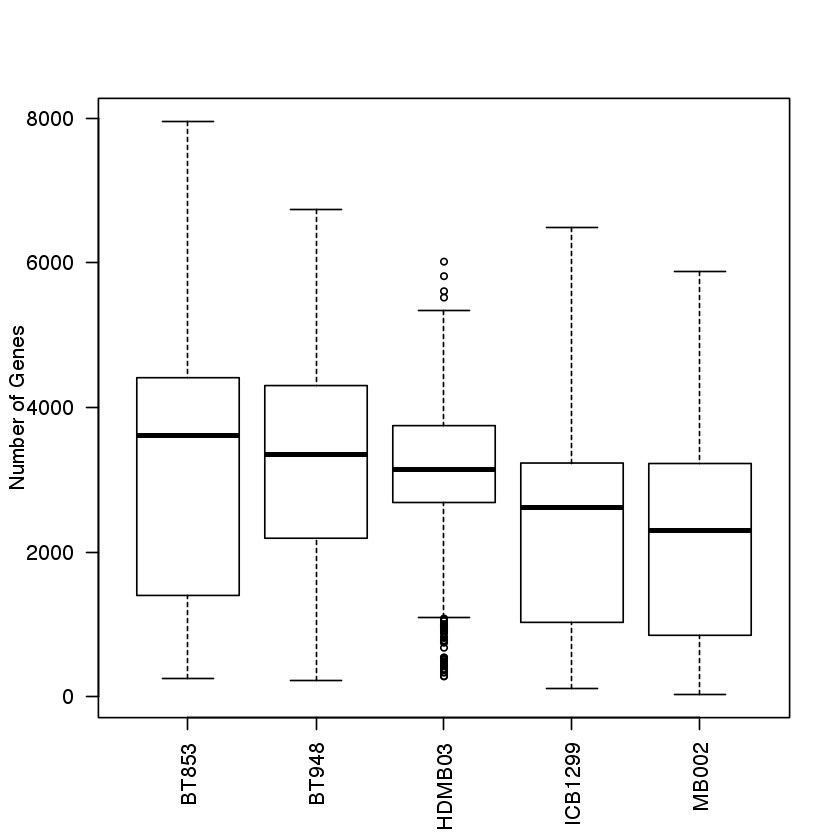

[1] 0.04853513 0.07117018 0.08352550 0.04349840 0.04295462

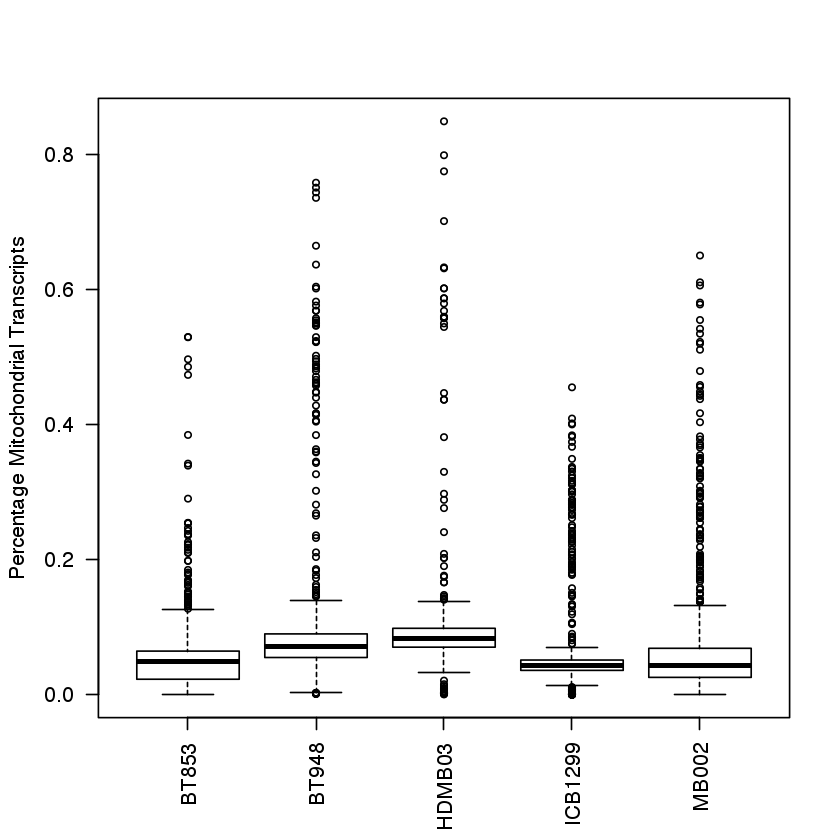

In [70]:
a <- boxplot(nUMI~Sample,
        data=meta,
        notch = F,
        ylab = "Number of Transcripts",
        las = 2,
        outcex= 0.6
)
a$stats[3,]

b <- boxplot(nGene~Sample,
        data=meta,
        notch = F,
        ylab = "Number of Genes",
        las = 2,
        outcex= 0.6
)
b$stats[3,]

c <- boxplot(percent.mito~Sample,
        data=meta,
        notch = F,
        ylab = "Percentage Mitochondrial Transcripts",
        las = 2,
        outcex= 0.6
)
c$stats[3,]

---
## 2.3 Identify outliers based on mitochondrial content
---

Decided to remove cells >30% Mt.




In [28]:
#meta <- read.table('~/Desktop/SinghWnt_June2018/SHH_REMOVED/data/metadata_aggregate.txt', header = T)
#head(meta)

In [77]:
#plot how many cells are above a given Mt threshol
# seq(x0, 6, 0.01)

mt.threshold <- seq(0, 1, 0.05)

In [85]:
all <- c()

for (i in 1:length(mt.threshold)){
    
    all[i] <- table(meta$percent.mito >= mt.threshold[i])[2]
    
}

all[is.na(all)] <- 0
all[1] <- 4183
all

[1] 4183 2460  600  315  257  199  151  113   95   74   55   40   19   10    8
[16]    5    1    0    0    0    0

In [89]:
table(meta$percent.mito >= 0.3)


FALSE  TRUE 
 4032   151 

In [88]:
#want to draw a cutoff across all the libraries combined
#Picked 30%, this seems reasonable and only removes 

#pdf("Figure6_MtCutoff.pdf")

#plot(all, 
#     mt.threshold,
#    xlab= "Number of Cells Removed",
#    ylab = "Mitochondrial Percent Cutoff",
#    main = "8 / 4183 cells removed for >20% mito content")
#abline(h=0.2, lty = 2, col = "red")
#abline(v=8, lty = 2, col = "red")

#dev.off()

---
## 2.4 Identify outliers based on genes and UMIs
---

Decided to use upper and lower limit of 4 MAD on a per library basis to remove cells. 

In [90]:
sample.names <- unique(meta$Sample)

for (i in 1:length(sample.names)){
    
    print(sample.names[i])
    df <- meta[meta$Sample == sample.names[i], ]

    poorQ.Mt <- row.names(df[df$percent.mito > 0.3, ])
    print(length(poorQ.Mt))
    
    }

[1] BT853
Levels: BT853 BT948 HDMB03 ICB1299 MB002
[1] 8
[1] BT948
Levels: BT853 BT948 HDMB03 ICB1299 MB002
[1] 53
[1] HDMB03
Levels: BT853 BT948 HDMB03 ICB1299 MB002
[1] 23
[1] ICB1299
Levels: BT853 BT948 HDMB03 ICB1299 MB002
[1] 23
[1] MB002
Levels: BT853 BT948 HDMB03 ICB1299 MB002
[1] 44


In [91]:
suppressMessages(library(scran))
suppressMessages(library(scater))

In [92]:
upper.limit <- function(metric, nmads){
               cur.med <- median(log10(metric), na.rm = TRUE)
               cur.mad <- mad(log10(metric), center = cur.med, na.rm = TRUE)
               cur.med + nmads * cur.mad }

lower.limit <- function(metric, nmads){
               cur.med <- median(log10(metric), na.rm = TRUE)
               cur.mad <- mad(log10(metric), center = cur.med, na.rm = TRUE)
               cur.med - nmads * cur.mad }

mito.limit <- function(metric, nmads){
               cur.med <- median(metric, na.rm = TRUE)
               cur.mad <- mad(metric, center = cur.med, na.rm = TRUE)
               cur.med + nmads * cur.mad }

In [94]:
sample.names <- unique(meta$Sample)
sample.names

[1] BT853   BT948   HDMB03  ICB1299 MB002  
Levels: BT853 BT948 HDMB03 ICB1299 MB002

In [96]:
sample.names <- unique(meta$Sample)

for (i in 1:length(sample.names)){
    
    sample <- sample.names[i]
    nmad <- 4
    df <- meta[meta$Sample == sample, ]
    
    #calculate cutoffs

    upper.UMI <- 10^upper.limit(df$nUMI, nmad)
    lower.UMI <- 10^lower.limit(df$nUMI, nmad)
    cells.pass.UMI <- sum(df$nUMI > lower.UMI & df$nUMI < upper.UMI)

    upper.gene <- 10^upper.limit(df$nGene, nmad)
    lower.gene <- 10^lower.limit(df$nGene, nmad)
    cells.pass.Gene <- sum(df$nGene > lower.gene & df$nGene < upper.gene)
    
    #print threshold info out

    print(sample)
    print(paste("Total number of cells:", nrow(df)))

    print(paste("Lower nUMI cutoff:", round(lower.UMI, 0)))
    print(paste("Upper nUMI cutoff:", round(upper.UMI, 0)))
    print(paste("Cells remaining after UMI filtering:", cells.pass.UMI))

    print(paste("Lower nGene cutoff:",  round(lower.gene,0)))
    print(paste("Upper nGene cutoff:",  round(upper.gene, 0)))
    print(paste("Cell remaining after Gene filtering:", cells.pass.Gene))
    
    #write out list of barcodes for a given sample that are to be removed
    #include percent.mito in this as well

    poorQ.UMI <- row.names(df[isOutlier(df$nUMI, nmads = 4, type = "both", log = TRUE), ])
    #length(poorQ.UMI)

    poorQ.gene <- row.names(df[isOutlier(df$nGene, nmads = 4, type = "both", log = TRUE), ])
    print(length(poorQ.gene))

    poorQ.Mt <- row.names(df[df$percent.mito > 0.3, ])
    print(length(poorQ.Mt))

    poorQ.cells <- unique(c(poorQ.UMI, 
                       poorQ.gene,
                       poorQ.Mt))
    

    print(paste("Number of PoorQ cells removed:", length(poorQ.cells)))

    write.table(poorQ.cells,
            file = paste("~/Desktop/SinghWnt_June2018/SHH_REMOVED/data/", sample, "_poorQcells.txt", sep =""),
           quote = F,
           row.names = F,
           col.names = F)
    
    
    
    #plot nGene and nUMI with cutoffs for a single library

    plot.name <- paste("~/Desktop/SinghWnt_June2018/SHH_REMOVED/figures/Figure7", sample, "_GeneUMIFilt.pdf")
    pdf(plot.name)

    a <- ggplot(df, aes(nUMI, nGene)) + geom_point(shape = 1, 
                                        colour = ifelse(df$nUMI > upper.UMI | 
                                                        df$nUMI < lower.UMI |
                                                        df$nGene > upper.gene |
                                                        df$nGene < lower.gene,
                                                        "red","black")) + theme(axis.text = element_text(size=6),
                                                        axis.title.y = element_text(size=10),
                                                        axis.title.x = element_text(size=10)) + ggtitle(sample) +
     theme_bw() + theme(panel.border = element_blank(), panel.grid.major = element_blank(),
    panel.grid.minor = element_blank(), axis.line = element_line(colour = "black"))

    a <- ggExtra::ggMarginal(a, type = "histogram", fill = "white") 

    print(a)

    dev.off()
    
}




[1] BT853
Levels: BT853 BT948 HDMB03 ICB1299 MB002
[1] "Total number of cells: 1159"
[1] "Lower nUMI cutoff: 665"
[1] "Upper nUMI cutoff: 280913"
[1] "Cells remaining after UMI filtering: 1130"
[1] "Lower nGene cutoff: 651"
[1] "Upper nGene cutoff: 19979"
[1] "Cell remaining after Gene filtering: 1066"
[1] 93
[1] 8
[1] "Number of PoorQ cells removed: 101"
[1] BT948
Levels: BT853 BT948 HDMB03 ICB1299 MB002
[1] "Total number of cells: 714"
[1] "Lower nUMI cutoff: 657"
[1] "Upper nUMI cutoff: 362439"
[1] "Cells remaining after UMI filtering: 698"
[1] "Lower nGene cutoff: 576"
[1] "Upper nGene cutoff: 19532"
[1] "Cell remaining after Gene filtering: 683"
[1] 31
[1] 53
[1] "Number of PoorQ cells removed: 72"
[1] HDMB03
Levels: BT853 BT948 HDMB03 ICB1299 MB002
[1] "Total number of cells: 855"
[1] "Lower nUMI cutoff: 3678"
[1] "Upper nUMI cutoff: 87031"
[1] "Cells remaining after UMI filtering: 805"
[1] "Lower nGene cutoff: 1193"
[1] "Upper nGene cutoff: 8269"
[1] "Cell remaining after Gene f

---
## 2.5 QC Summary
---

Based on the plots above, the following threshold for filtering out "poor quality" and "outlier" cells has been chosen. Poor quality cells are defined as those being above or below the lower or upper limit of 4 MAD within each library, or habing >30% Mt UMI content.

|Sample|Cells|nUMI Cutoffs|nGene Cutoffs|% mito Cutoff|Cells Removed|Cells Remaining|
|---|---|
|BT853|1,159|389-159,213|370-17,680|30|76|1,083|
|BT948|714|512-286,299|465-18,141|30|71|643|
|BT992|1,311|2,578-69,281|1,419-7,880|30|99|1,212|
|HDMB03|855|3,201-76,841|1,071-7,918|30|59|796|
|ICB1299|699|1,007-70,416|438-10,692|30|151|548|
|MB002|756|46-1,187,501|82-39,936|30|55|701|

---
## 2.5 Filter Raw Expression Matrix
---

Remove poor Q cells from expression matrix. Use this filtered HQ matrix for all downstream analysis.

In [1]:
suppressMessages(library(Seurat))

Warning message:
“package ‘Seurat’ was built under R version 3.4.4”Warning message:
“package ‘cowplot’ was built under R version 3.4.3”Warning message:
“package ‘Matrix’ was built under R version 3.4.4”

In [109]:
#read in raw count matrix containing all cells identified by Dropbead

Dropbead.dat <- read.table("~/Desktop/SinghWnt_June2018/SHH_REMOVED/data/Dropbead_rawCounts_aggregate.txt", header = T)

In [111]:
colnames(Dropbead.dat)[1:10]

[1] "AAACCTGAGTCAATAG.1" "AAACCTGGTCATTAGC.1" "AAACCTGTCATTATCC.1"
 [4] "AAACCTGTCTTACCGC.1" "AAACGGGGTCACCCAG.1" "AAACGGGGTCTAGCGC.1"
 [7] "AAACGGGTCCGCATCT.1" "AAAGATGAGGTGTGGT.1" "AAAGATGCATACCATG.1"
[10] "AAAGATGCATGTCTCC.1"

In [113]:
#remove poorQ identified in previous sections

poorQcells <- c()
 
file.path <- "~/Desktop/SinghWnt_June2018/SHH_REMOVED/data/"
files <- list.files(file.path, pattern = "poorQcells.txt")
#files

for (i in 1:length(files)){
    
    a <- read.table(paste(file.path, files[i], sep = ""), stringsAsFactors = F)
    print(dim(a))
    
    poorQcells <- append(poorQcells, a$V1)
    
    
}

length(poorQcells)
head(poorQcells)



[1] 101   1
[1] 72  1
[1] 60  1
[1] 151   1
[1] 56  1


[1] 440

[1] "AAATGCCCATGAAGTA-1" "AAATGCCGTGGTACAG-1" "ACGTCAACACGTGAGA-1"
[4] "AGATCTGAGAGTAATC-1" "AGTGAGGAGGGTATCG-1" "CATCAGAGTCTTGTCC-1"

In [114]:
poorQcells <- gsub("-", ".", poorQcells)
head(poorQcells)
tail(poorQcells)

[1] "AAATGCCCATGAAGTA.1" "AAATGCCGTGGTACAG.1" "ACGTCAACACGTGAGA.1"
[4] "AGATCTGAGAGTAATC.1" "AGTGAGGAGGGTATCG.1" "CATCAGAGTCTTGTCC.1"

[1] "TGCACCTTCGTCCGTT.5" "TGCGGGTTCTTAACCT.5" "TGGGCGTAGCCGTCGT.5"
[4] "TGGGCGTTCATTCACT.5" "TTAGGCAAGACAGACC.5" "TTAGTTCCAGGAATGC.5"

In [115]:
dim(Dropbead.dat)
Dropbead.filtered.dat <- Dropbead.dat[ ,!(colnames(Dropbead.dat) %in% poorQcells)]
dim(Dropbead.filtered.dat)
table(colnames(Dropbead.filtered.dat) %in% poorQcells)
#str(Dropbead.filtered.dat)

[1] 33694  4183

[1] 33694  3743


FALSE 
 3743 

In [116]:
write.table(Dropbead.filtered.dat,
           file = '~/Desktop/SinghWnt_June2018/SHH_REMOVED/data/Dropbead_filteredQ_rawCounts_aggregate.txt',
           quote = F,
           col.names = T,
           row.names = T,
           sep = "\t")

In [118]:
#filter the metadata as well and re-write out

meta <- read.table("~/Desktop/SinghWnt_June2018/SHH_REMOVED/data/metadata_aggregate.txt", header = T)
rownames(meta) <- gsub("-", ".", rownames(meta))
head((rownames(meta)))
tail((rownames(meta)))
dim(meta)
meta.filtered <- meta[!(rownames(meta) %in% poorQcells), ]
#table(rownames(meta.filtered) %in% poorQcells)
dim(meta.filtered)


write.table(meta.filtered,
           file = '~/Desktop/SinghWnt_June2018/SHH_REMOVED/data/metadata_filtered_aggregate.txt',
           quote = F,
           col.names = T,
           row.names = T,
           sep = "\t")

[1] "AAACCTGAGTCAATAG.1" "AAACCTGGTCATTAGC.1" "AAACCTGTCATTATCC.1"
[4] "AAACCTGTCTTACCGC.1" "AAACGGGGTCACCCAG.1" "AAACGGGGTCTAGCGC.1"

[1] "TTTGCGCCAGTCTTCC.5" "TTTGCGCCATTGGCGC.5" "TTTGCGCTCTTGCATT.5"
[4] "TTTGGTTCACAACTGT.5" "TTTGGTTTCACTATTC.5" "TTTGTCATCGTATCAG.5"

[1] 4183    8

[1] 3743    8

---
# 3.0 Normalize and Scale Gene Expression
---

In [119]:
#read in raw counts and metadata for matrix containing HIGH QUALITY CELLS ONLY

raw.dat <- read.table('~/Desktop/SinghWnt_June2018/SHH_REMOVED/data/Dropbead_filteredQ_rawCounts_aggregate.txt', 
                     header = T)

meta <- read.table("~/Desktop/SinghWnt_June2018/SHH_REMOVED/data/metadata_filtered_aggregate.txt",
                  header = T)


In [120]:
dim(raw.dat)
raw.dat[1:10, 1:10]

dim(meta)
head(meta)

table(colnames(raw.dat) %in% rownames(meta))

[1] 33694  3743

,AAACCTGAGTCAATAG.1,AAACCTGGTCATTAGC.1,AAACCTGTCATTATCC.1,AAACCTGTCTTACCGC.1,AAACGGGGTCACCCAG.1,AAACGGGGTCTAGCGC.1,AAACGGGTCCGCATCT.1,AAAGATGAGGTGTGGT.1,AAAGATGCATACCATG.1,AAAGATGCATGTCTCC.1
RP11-34P13.3,0,0,0,0,0,0,0,0,0,0
FAM138A,0,0,0,0,0,0,0,0,0,0
OR4F5,0,0,0,0,0,0,0,0,0,0
RP11-34P13.7,0,0,0,0,0,0,0,0,0,0
RP11-34P13.8,0,0,0,0,0,0,0,0,0,0
RP11-34P13.14,0,0,0,0,0,0,0,0,0,0
RP11-34P13.9,0,0,0,0,0,0,0,0,0,0
FO538757.3,0,0,0,0,0,0,0,0,0,0
FO538757.2,0,1,0,0,0,0,0,1,0,0
AP006222.2,2,1,0,0,3,0,0,1,0,0


[1] 3743    8

,nGene,nUMI,orig.ident,percent.mito,Num.Reads,Sample,Subgroup,Stage
AAACCTGAGTCAATAG.1,4784,29465,Singh,0.049689441,57223,BT853,WNT,Primary
AAACCTGGTCATTAGC.1,4068,18474,Singh,0.004493774,35775,BT853,WNT,Primary
AAACCTGTCATTATCC.1,706,1535,Singh,0.001955671,9672,BT853,WNT,Primary
AAACCTGTCTTACCGC.1,2001,5328,Singh,0.235779989,15362,BT853,WNT,Primary
AAACGGGGTCACCCAG.1,5208,27359,Singh,0.040176939,49766,BT853,WNT,Primary
AAACGGGGTCTAGCGC.1,2873,7758,Singh,0.140294269,39238,BT853,WNT,Primary



TRUE 
3743 

In [127]:
#when creating Seurat object now, do not apply any cell based filtering
#a gene must be expressed in at least 7 cells across the entire data set which corresponds to 
#about 1% of the smallest number of cells for a given library (1% of 548 = round down to 5 cells)

Wnt_medullo <- CreateSeuratObject(raw.data = raw.dat, 
                                  min.cells = 5, 
                                  min.genes = 0, 
                                  project = "Singh")

In [128]:
#add Metadata to the seurat object

Wnt_medullo <- AddMetaData(object = Wnt_medullo, 
                          metadata = meta)

In [129]:
#Lognormalize the data

Wnt_medullo <- NormalizeData(object = Wnt_medullo, 
                            normalization.method = "LogNormalize", 
                            scale.factor = 10000)

In [130]:
#Scale and centre (z-score) data rows aka genes

Wnt_medullo <- ScaleData(object = Wnt_medullo)

Scaling data matrix


In [131]:
save(Wnt_medullo, file = "~/Desktop/Samwise/projects/BTSCs_scRNAseq/Wnt_medullo_noSHH.rdata")

---
# 4.0 Gene Signature Scoring
----

David has provided 4 gene signatures, defining each of the medullo subgroups.  
We want to score every cell for each signature usign the AddModuleScore() function in Seurat, and then make a heatmap for each signature, broken up by cell line.


---
## 4.1 Clean up signatures
---

> Singh Lab has decided they are only interested in the Wnt signature
> score for subgroup and canonical Wnt only. 
  
|Signature|Genes in Sig|Genes Missing||
|---|---|
|Wnt|27|3|WIF1, DKK4, GALNTL2|
|Shh|42|1|BMP5|
|Group3|14|0|
|Group4|27|1|GPR12|


In [3]:
load("~/Desktop/Samwise/projects/BTSCs_scRNAseq/Wnt_medullo_noSHH.rdata")

In [8]:
table(Wnt_medullo@meta.data$Sample)
dim(Wnt_medullo@data)
library(Seurat)


  BT853   BT948  HDMB03 ICB1299   MB002 
   1058     642     795     548     700 

[1] 18784  3743

Warning message:
“package ‘Seurat’ was built under R version 3.4.4”Loading required package: ggplot2
Warning message:
“package ‘ggplot2’ was built under R version 3.4.4”Loading required package: cowplot
Warning message:
“package ‘cowplot’ was built under R version 3.4.4”
Attaching package: ‘cowplot’

The following object is masked from ‘package:ggplot2’:

    ggsave



In [9]:
sigs <- read.csv("~/Downloads/SinghWnt_SuppTables - Table S2. (2).csv", stringsAsFactors = F)
head(sigs)

WNT,SHH,GR_3,GR_4,KEGG_WNT,CANONICAL_WNT,WNT_ANNOTATIONS
EPHA7,DYRK1B,GNB3,ARHGEF12,APC,WNT1,Ligand
FZD10,ARRB2,GNGT1,RND1,APC2,WNT10A,Ligand
BMP4,GLI2,RCVRN,RHOT1,AXIN1,WNT16,Ligand
WNT16,GLI3,PDE6H,DPYSL4,AXIN2,WNT2,Ligand
EPHA4,HHIP,MYC,DIRAS3,BTRC,WNT2B,Ligand
NFATC4,GLI1,NLK,FNBP1,CACYBP,WNT3,Ligand


In [10]:
## CANONICAL WNT SCORING

CANONICAL_WNT <- sigs[ ,6]
CANONICAL_WNT <- CANONICAL_WNT[CANONICAL_WNT != ""] 
CANONICAL_WNT <- gsub(" ", "", CANONICAL_WNT)
CANONICAL_WNT[CANONICAL_WNT == "CK1"] <- "CSNK1A1"

CANONICAL_WNT <- CANONICAL_WNT[(CANONICAL_WNT %in% row.names(Wnt_medullo@data))]
length(CANONICAL_WNT)

Wnt_medullo <- AddModuleScore(object = Wnt_medullo,
                                    genes.list = list(CANONICAL_WNT),
                                    ctrl.size = 100, 
                                    enrich.name = "CANONICAL_WNT",
                                    n.bin = 25,
                                    seed = 123
                                   )

[1] 46

In [11]:
## SUBGROUP SCORING

Wnt <- sigs[ ,1]
Wnt <- Wnt[Wnt != ""] 
Wnt <- gsub(" ", "", Wnt)#remove empty entries
Wnt

Group3 <- sigs[ ,3]
Group3 <- Group3[Group3 != ""]
Group3 <- gsub(" ", "", Group3)
Group3 <- gsub("p38", "MAPK14", Group3)#remove empty entries
Group3

Group4 <- sigs[ ,4]
Group4 <- Group4[Group4 != ""] 
Group4 <- gsub(" ", "", Group4)
Group4 <- gsub("C12ORF5", "TIGAR", Group4)#remove empty entries
Group4

[1] "EPHA7"   "FZD10"   "BMP4"    "WNT16"   "EPHA4"   "NFATC4"  "SLIT2"  
 [8] "EPHA3"   "ADAM12"  "PRKCD"   "FZD6"    "ADAM19"  "PLCB1"   "SEMA3B" 
[15] "AXIN2"   "WIF1"    "DKK4"    "WNT16"   "DKK2"    "LEF1"    "KREMEN1"
[22] "DKK1"    "GLT8D2"  "GALNT7"  "GALNT14" "GALNT12" "GALNTL2"

[1] "GNB3"    "GNGT1"   "RCVRN"   "PDE6H"   "MYC"     "NLK"     "TGFB1"  
 [8] "TGFBR3"  "PPP2R2B" "SLC17A7" "SLC1A7"  "RXRG"    "MAPK14"  "EEF2K"

[1] "ARHGEF12" "RND1"     "RHOT1"    "DPYSL4"   "DIRAS3"   "FNBP1"   
 [7] "GRK4"     "GRM8"     "RGS7"     "ADCY1"    "STAT3"    "PDE4B"   
[13] "AKAP9"    "CHRM3"    "PDE1C"    "HTR2C"    "GPR12"    "PDE1C"   
[19] "KAT2B"    "CCND2"    "GADD45G"  "TIGAR"    "HIPK2"    "TP53BP2" 
[25] "CACNA1C"  "GNG2"     "CACNA1A"

In [12]:
Wnt <- Wnt[(Wnt %in% row.names(Wnt_medullo@data))]
length(Wnt)

Group3 <- Group3 [(Group3  %in% row.names(Wnt_medullo@data))]
length(Group3 )

Group4 <- Group4[(Group4 %in% row.names(Wnt_medullo@data))]
length(Group4)

[1] 24

[1] 14

[1] 24

In [13]:
Wnt_medullo <- AddModuleScore(object = Wnt_medullo,
                                    genes.list = list(Wnt),
                                    ctrl.size = 100, 
                                    enrich.name = "Wnt",
                                    n.bin = 25,
                                    seed = 123
                                   )

In [14]:
Wnt_medullo <- AddModuleScore(object = Wnt_medullo,
                                    genes.list = list(Group3),
                                    ctrl.size = 100, 
                                    enrich.name = "Group3",
                                    n.bin = 25,
                                    seed = 123
                                   )

In [15]:
Wnt_medullo <- AddModuleScore(object = Wnt_medullo,
                                    genes.list = list(Group4),
                                    ctrl.size = 100, 
                                    enrich.name = "Group4",
                                    n.bin = 25,
                                    seed = 123
                                   )

In [16]:
colnames(Wnt_medullo@meta.data) <- gsub("1", "", colnames(Wnt_medullo@meta.data))

#Wnt_medullo@meta.data[9:12] <- NULL
head(Wnt_medullo@meta.data)

,nGene,nUMI,orig.ident,percent.mito,Num.Reads,Sample,Subgroup,Stage,CANONICAL_WNT,Wnt,Group3,Group4
AAACCTGAGTCAATAG.1,4784,29465,Singh,0.049689441,57223,BT853,WNT,Primary,-0.01846389,0.04983821,-0.2401601,0.00314158
AAACCTGGTCATTAGC.1,4068,18474,Singh,0.004493774,35775,BT853,WNT,Primary,-0.02817674,0.01166084,-0.2143063,-0.03328804
AAACCTGTCATTATCC.1,706,1535,Singh,0.001955671,9672,BT853,WNT,Primary,-0.06569672,0.05794383,0.1483865,0.18457608
AAACCTGTCTTACCGC.1,2001,5328,Singh,0.235779989,15362,BT853,WNT,Primary,0.04977647,0.07281592,-0.2579663,0.18638491
AAACGGGGTCACCCAG.1,5208,27359,Singh,0.040176939,49766,BT853,WNT,Primary,0.01141360,0.01197165,-0.2393996,-0.06656730
AAACGGGGTCTAGCGC.1,2873,7758,Singh,0.140294269,39238,BT853,WNT,Primary,0.05792443,0.09911536,-0.1969155,0.05837574


### PLOT HEATMAP

In [17]:
suppressMessages(library(pheatmap))
suppressMessages(library(RColorBrewer))
suppressMessages(library(viridis))
suppressMessages(library(scales))
suppressMessages(library(Seurat))

Warning message:
“package ‘pheatmap’ was built under R version 3.4.4”Warning message:
“package ‘viridis’ was built under R version 3.4.4”Warning message:
“package ‘viridisLite’ was built under R version 3.4.3”

In [18]:
# DEFINE GENE SIGNATURE SPECIFIC EXPRESSION MATRIX

#subset the normalzied expression matrix by gene sigs
#add Wnt signature score data to matrix

mat <- Wnt_medullo@data[rownames(Wnt_medullo@data) %in% CANONICAL_WNT,]
dim(mat)
mat[1:5, 1:5]

[1]   45 3743

5 x 5 sparse Matrix of class "dgCMatrix"
         AAACCTGAGTCAATAG.1 AAACCTGGTCATTAGC.1 AAACCTGTCATTATCC.1
DVL1              .                          .                  .
CTNNBIP1          .                          .                  .
WNT2B             .                          .                  .
BCL9              .                          .                  .
TCF7L1            0.2922283                  .                  .
         AAACCTGTCTTACCGC.1 AAACGGGGTCACCCAG.1
DVL1                      .          0.5487576
CTNNBIP1                  .          0.3115577
WNT2B                     .          0.3115577
BCL9                      .          0.3115577
TCF7L1                    .          .        

In [19]:
mat <- rbind(mat, 
             Wnt_medullo@meta.data$Wnt, 
             Wnt_medullo@meta.data$Group3,
             Wnt_medullo@meta.data$Group4,
             Wnt_medullo@meta.data$CANONICAL_WNT
            )
dim(mat)

[1]   49 3743

In [20]:
row.names(mat)[46:49] <- c("Wnt_signature",
                           "Group3_signature",
                           "Group4_signature",
                           "Canonical_Wnt"
                           )

In [21]:
rownames(mat)

[1] "DVL1"             "CTNNBIP1"         "WNT2B"            "BCL9"            
 [5] "TCF7L1"           "FZD7"             "FZD5"             "WNT10A"          
 [9] "CTNNB1"           "GSK3B"            "RUVBL1"           "CTBP1"           
[13] "CXXC4"            "LEF1"             "APC"              "TCF7"            
[17] "CSNK1A1"          "SFRP4"            "FZD9"             "FZD1"            
[21] "WNT16"            "PORCN"            "FZD3"             "SFRP1"           
[25] "FZD6"             "DKK3"             "LRP5"             "FZD4"            
[29] "DIXDC1"           "FZD8"             "DKK1"             "FRAT1"           
[33] "LRP6"             "PYGO1"            "AXIN1"            "NKD1"            
[37] "DVL2"             "FZD2"             "WNT3"             "AXIN2"           
[41] "CSNK2A1"          "AES"              "GSK3A"            "EP300"           
[45] "WNT7B"            "Wnt_signature"    "Group3_signature" "Group4_signature"
[49] "Canonical_Wnt"

In [22]:
#Order cells within sample by Wnt Signature score and combine matrices


BT853 <- mat[,(Wnt_medullo@meta.data$Sample == "BT853")]
col_order <- order(BT853[rownames(BT853) == "Wnt_signature",]) #order cells by Wnt signature
BT853 <- BT853[ ,col_order]

row_order <- c('Wnt_signature',
            'Group3_signature',
            'Group4_signature',
            'Canonical_Wnt',
           CANONICAL_WNT
           )

mat_ordered <- BT853[match(row_order, rownames(BT853)),]
dim(mat_ordered)

[1]   50 1058

In [23]:
samples <- c("HDMB03", "MB002", "BT948", "ICB1299")

In [24]:
for (i in 1:length(samples)){
    
    print(samples[i])
    df <- mat[,(Wnt_medullo@meta.data$Sample == samples[i])]
    col_order <- order(df[rownames(df) == "Wnt_signature",]) #order cells by Wnt signature
    df <- df[ ,col_order]

    row_order <- c('Wnt_signature',
            'Group3_signature',
            'Group4_signature',
            'Canonical_Wnt',
            CANONICAL_WNT
           )
    
    df <- df[match(row_order, rownames(df)),]
    print(dim(df))

    mat_ordered <- cbind(mat_ordered, df)
    
    
}

[1] "HDMB03"
[1]  50 795
[1] "MB002"
[1]  50 700
[1] "BT948"
[1]  50 642
[1] "ICB1299"
[1]  50 548


In [25]:
for (i in 1:nrow(mat_ordered)){ 
    
    mat_ordered[i,] <- scale(mat_ordered[i,]) #scale each row (z-score)
   
}

In [26]:
#crush the scale
mat_ordered[mat_ordered > 3] <- 3
mat_ordered[mat_ordered < (-3)] <- -3

In [27]:
breaks <- c(1058, 
            (1058+795),
            (1058+795+700),
            (1058+795+700+642),
            (1058+795+700+642+548)   
           )
breaks

breaksList <- seq(-3, 3, by = 0.25) 

[1] 1058 1853 2553 3195 3743

In [28]:
row_breaks <- c(3,4,9,20,22,40)

In [29]:
annotat <- Wnt_medullo@meta.data
#head(annotat)
mat_col <- annotat[ ,c(6:8)]
head(mat_col)


,Sample,Subgroup,Stage
AAACCTGAGTCAATAG.1,BT853,WNT,Primary
AAACCTGGTCATTAGC.1,BT853,WNT,Primary
AAACCTGTCATTATCC.1,BT853,WNT,Primary
AAACCTGTCTTACCGC.1,BT853,WNT,Primary
AAACGGGGTCACCCAG.1,BT853,WNT,Primary
AAACGGGGTCTAGCGC.1,BT853,WNT,Primary


In [30]:
CANONICAL_WNT <- sigs[1:56 ,6:7]
annotat_row <- CANONICAL_WNT[ CANONICAL_WNT$CANONICAL_WNT %in% rownames(mat_ordered), ]
dim(annotat_row)
dim(CANONICAL_WNT)

[1] 45  2

[1] 56  2

In [31]:
rownames(annotat_row) <- annotat_row$CANONICAL_WNT
annotat_row$CANONICAL_WNT <- NULL
colnames(annotat_row) <- "Canonical_Wnt_Annotation"
table(annotat_row$Canonical_Wnt_Annotation)


          Extracellular Mediator                           Ligand 
                               2                                5 
Membrane and Cytoplasmic Protein                  Nuclear Protein 
                              17                               10 
                        Receptor 
                              11 

In [32]:
#Assign colours to the annotations

mat_colors <- list(Sample = brewer.pal(5, "Set1"),
                   
                   Subgroup = c("#a6611a",
                                "#80cdc1",
                                "#018571"
                                ),
                   
                   Stage = c("grey", "black"),
                   
                   Canonical_Wnt_Annotation = c("#f6eff7", "#bdc9e1", "#67a9cf", "#1c9099", "#016c59")
                   
    
                  )
                   

names(mat_colors$Sample) <- unique(mat_col$Sample)
names(mat_colors$Subgroup) <- unique(mat_col$Subgroup)
names(mat_colors$Stage) <- unique(mat_col$Stage)
names(mat_colors$Canonical_Wnt_Annotation) <- unique(annotat_row$Canonical_Wnt_Annotation)

mat_colors

$Sample
    BT853     BT948    HDMB03   ICB1299     MB002 
"#E41A1C" "#377EB8" "#4DAF4A" "#984EA3" "#FF7F00" 

$Subgroup
      WNT      GR_4      GR_3 
"#a6611a" "#80cdc1" "#018571" 

$Stage
  Primary Recurrent 
   "grey"   "black" 

$Canonical_Wnt_Annotation
                          Ligand                         Receptor 
                       "#f6eff7"                        "#bdc9e1" 
          Extracellular Mediator Membrane and Cytoplasmic Protein 
                       "#67a9cf"                        "#1c9099" 
                 Nuclear Protein 
                       "#016c59"

In [33]:
pheatmap(mat = mat_ordered,
         border_color = NA,
         color = colorRampPalette(rev(brewer.pal(n = 11, name = "RdBu")))(length(breaksList)),
         show_colnames = FALSE,
         show_rownames = TRUE,
         annotation_col = mat_col,
         annotation_row = annotat_row,
         annotation_colors = mat_colors,
         drop_levels = TRUE,
         fontsize = 8,
         main = "",
         cluster_rows = FALSE,
         cluster_cols = FALSE,
         gaps_col = breaks,
         breaks = breaksList,
         gaps_row = row_breaks,
         annotation_names_row = FALSE,
         legend = TRUE,
         annotation_legend = TRUE,
         filename = "~/Desktop/SinghWnt_June2018/SHH_REMOVED/Canonical_WNt_nolegend_2.pdf"
)



dev.off()

null device 
          1

In [34]:
save(Wnt_medullo, file = "~/Desktop/Samwise/projects/BTSCs_scRNAseq/Wnt_medullo_noSHH.rdata")

---
# ENDDDDDD

In [50]:
write.table(as.matrix(mat),
            file = "~/Desktop/SinghWnt_June2018/SHH_REMOVED/data/SignatureScores_Wnt.txt",
            col.names = T,
            row.names =T,
            quote = F,
            sep = "\t"
           )

write.table(as.matrix(mat_ordered),
            file = "~/Desktop/SinghWnt_June2018/SHH_REMOVED/data/SignatureScores_scaled_Wnt.txt",
            col.names = T,
            row.names =T,
            quote = F,
            sep = "\t"
           )

In [49]:
write.table(as.matrix(Wnt_medullo@data),
            file = "~/Desktop/SinghWnt_June2018/SHH_REMOVED/data/Normalized_filtered_DGE.txt",
            col.names = T,
            row.names =T,
            quote = F,
            sep = "\t"
            )

---
## Dimensionality reduction and clustering
---

In [1]:
library(Seurat)
load("~/Desktop/Samwise/projects/SinghLab_scMedullo/data/Wnt_medullo_noSHH.rdata")

Warning message:
“package ‘Seurat’ was built under R version 3.4.4”Loading required package: ggplot2
Warning message:
“package ‘ggplot2’ was built under R version 3.4.4”Loading required package: cowplot
Warning message:
“package ‘cowplot’ was built under R version 3.4.4”
Attaching package: ‘cowplot’

The following object is masked from ‘package:ggplot2’:

    ggsave

Loading required package: Matrix
Warning message:
“package ‘Matrix’ was built under R version 3.4.4”

In [2]:
str(Wnt_medullo)

Formal class 'seurat' [package "Seurat"] with 20 slots
  ..@ raw.data    :'data.frame':	18784 obs. of  3743 variables:
  .. ..$ AAACCTGAGTCAATAG.1: int [1:18784] 0 0 2 0 0 0 0 0 0 0 ...
  .. ..$ AAACCTGGTCATTAGC.1: int [1:18784] 0 1 1 0 0 0 0 0 0 0 ...
  .. ..$ AAACCTGTCATTATCC.1: int [1:18784] 0 0 0 0 0 0 0 0 0 0 ...
  .. ..$ AAACCTGTCTTACCGC.1: int [1:18784] 0 0 0 0 0 0 0 0 0 0 ...
  .. ..$ AAACGGGGTCACCCAG.1: int [1:18784] 0 0 3 0 0 0 0 0 0 0 ...
  .. ..$ AAACGGGGTCTAGCGC.1: int [1:18784] 0 0 0 0 0 0 0 0 0 0 ...
  .. ..$ AAACGGGTCCGCATCT.1: int [1:18784] 0 0 0 0 0 0 0 0 0 0 ...
  .. ..$ AAAGATGAGGTGTGGT.1: int [1:18784] 0 1 1 0 0 0 0 0 0 0 ...
  .. ..$ AAAGATGCATACCATG.1: int [1:18784] 0 0 0 0 0 0 0 0 0 0 ...
  .. ..$ AAAGATGCATGTCTCC.1: int [1:18784] 0 0 0 0 0 0 0 0 0 0 ...
  .. ..$ AAAGATGGTCTAGGTT.1: int [1:18784] 0 0 0 0 0 1 0 0 0 0 ...
  .. ..$ AAAGCAACAAATTGCC.1: int [1:18784] 0 0 0 0 0 0 0 0 0 0 ...
  .. ..$ AAAGCAATCACGAAGG.1: int [1:18784] 0 0 0 0 0 0 0 0 0 0 ...
  .. ..$ A

[1] 4140

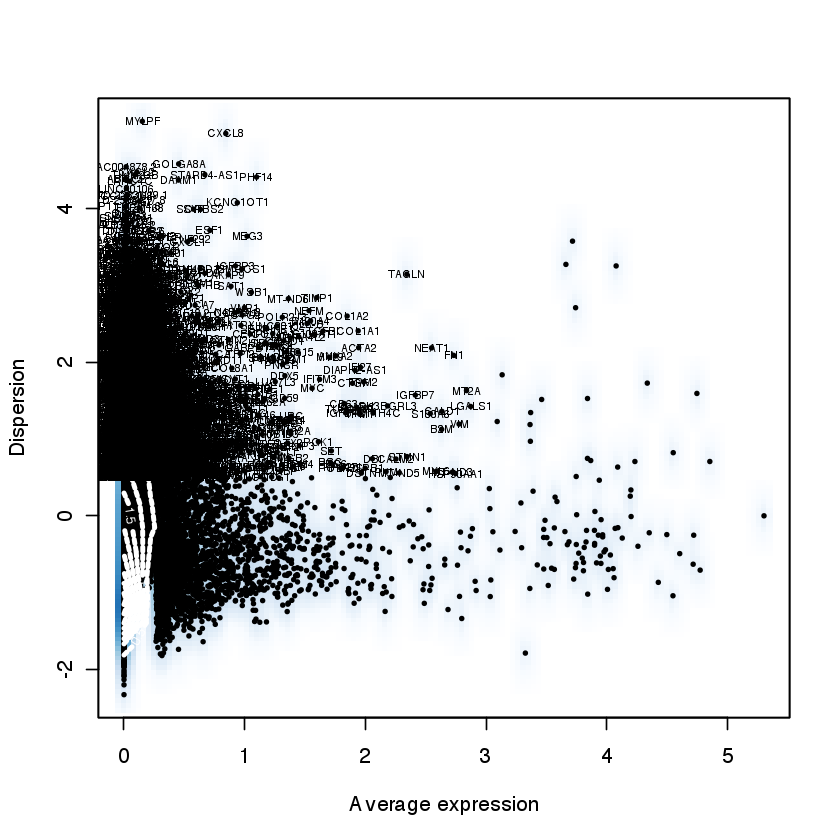

In [3]:
Wnt_medullo <- FindVariableGenes(object = Wnt_medullo, 
                          mean.function = ExpMean, 
                          dispersion.function = LogVMR, 
                          x.low.cutoff = 0.0125, 
                          x.high.cutoff = 3, 
                          y.cutoff = 0.5
                         )
length(x = Wnt_medullo@var.genes)

In [4]:
Wnt_medullo <- ScaleData(object = Wnt_medullo)

Scaling data matrix


In [5]:
Wnt_medullo <- RunPCA(object = Wnt_medullo, 
                      pc.genes = Wnt_medullo@var.genes, 
                      do.print = TRUE, 
                      pcs.print = 1:5, 
                      genes.print = 5)

[1] "PC1"
[1] "OTX2"   "HES6"   "STMN1"  "TMEM97" "MYC"   
[1] ""
[1] "FN1"    "COL1A2" "CAV1"   "SPARC"  "CTGF"  
[1] ""
[1] ""
[1] "PC2"
[1] "CHODL" "NEFL"  "CD24"  "DAND5" "NEFM" 
[1] ""
[1] "DBI"        "HBE1"       "HSP90AA1"   "GNGT1"      "DIAPH2-AS1"
[1] ""
[1] ""
[1] "PC3"
[1] "RPS4Y1"  "HSPB1"   "ZFAT"    "FABP5"   "COL27A1"
[1] ""
[1] "PNISR"  "WSB1"   "LUC7L3" "SON"    "TUBA1A"
[1] ""
[1] ""
[1] "PC4"
[1] "RPS4Y1"  "COL27A1" "ZFAT"    "NFASC"   "CCDC181"
[1] ""
[1] "TUBA1A" "TUBB2B" "PGK1"   "BNIP3"  "ACAT2" 
[1] ""
[1] ""
[1] "PC5"
[1] "STMN2"         "RP11-624J12.1" "DIAPH2-AS1"    "CASC8"        
[5] "RALGAPA1"     
[1] ""
[1] "UCHL1" "CLU"   "UBE2C" "PTTG1" "HMGB2"
[1] ""
[1] ""


In [6]:
Wnt_medullo <- ProjectPCA(object = Wnt_medullo, do.print = FALSE)

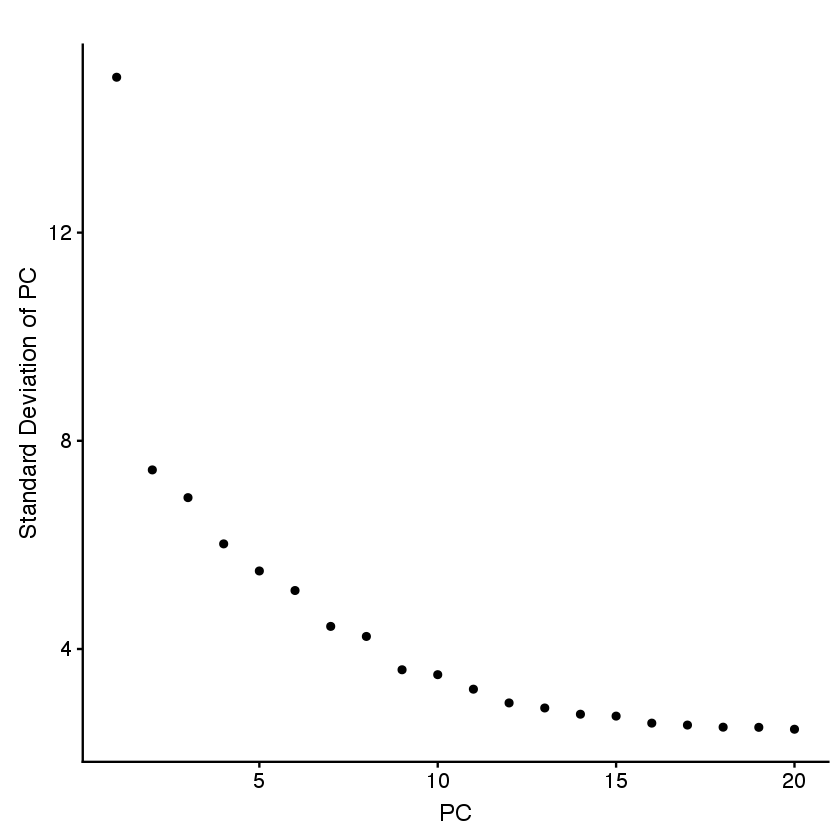

In [7]:
PCElbowPlot(object = Wnt_medullo) #pick 12 PCs to include in downstream analysis

In [8]:
Wnt_medullo <- FindClusters(object = Wnt_medullo , 
                            reduction.type = "pca", 
                            dims.use = 1:12, 
                            resolution = 0.6, 
                            print.output = 0, 
                            save.SNN = TRUE)

In [9]:
Wnt_medullo <- RunTSNE(object = Wnt_medullo, 
                       dims.use = 1:12, 
                       do.fast = TRUE)

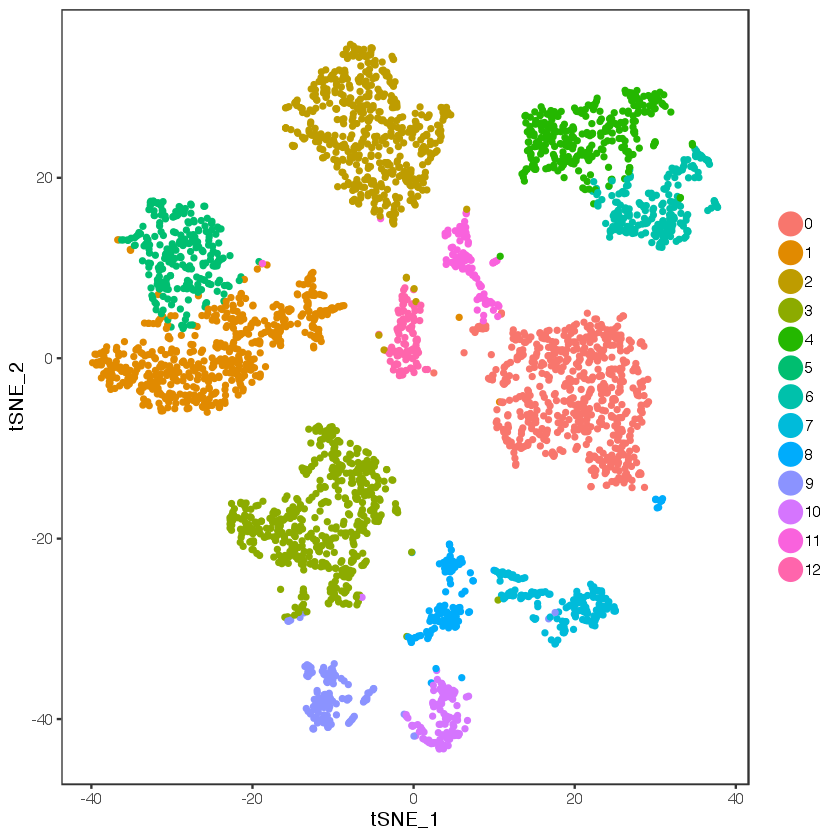

In [10]:
TSNEPlot(object = Wnt_medullo)

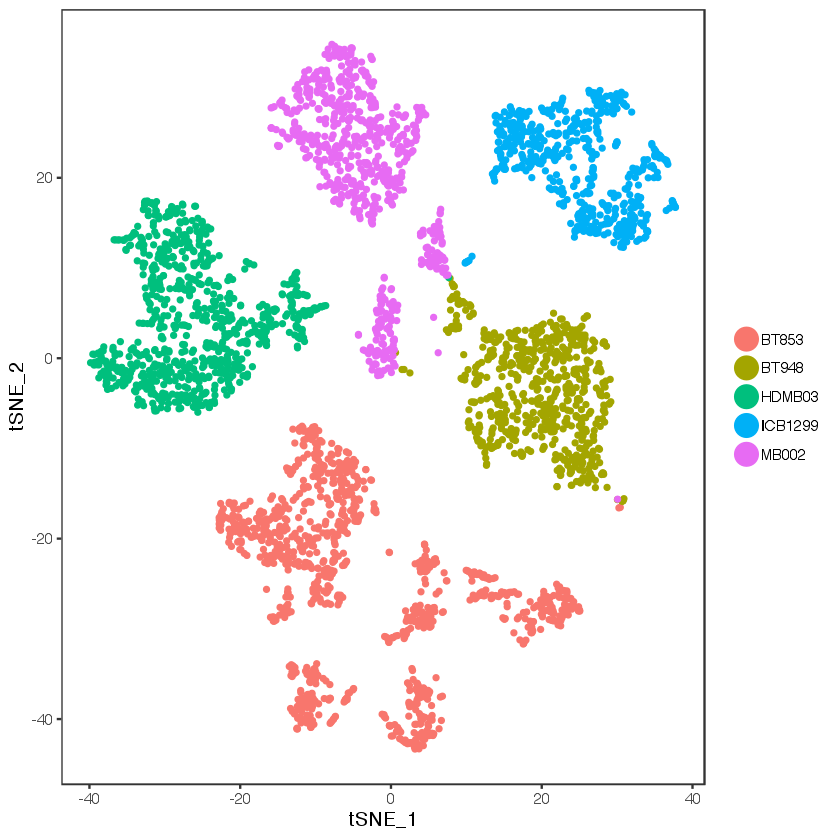

In [12]:
TSNEPlot(object = Wnt_medullo, group.by = "Sample")

In [13]:
save(Wnt_medullo, file = "~/Desktop/Samwise/projects/SinghLab_scMedullo/data/Wnt_medullo_noSHH.rdata")

In [47]:
#make data.frame

test <- cbind(Wnt_medullo@dr$tsne@cell.embeddings, Wnt_medullo@meta.data)
head(test)

,tSNE_1,tSNE_2,nGene,nUMI,orig.ident,percent.mito,Num.Reads,Sample,Subgroup,Stage,CANONICAL_WNT,Wnt,Group3,Group4,res.0.6
AAACCTGAGTCAATAG.1,-13.797797,-21.87077,4784,29465,Singh,0.049689441,57223,BT853,WNT,Primary,-0.01846389,0.04983821,-0.2401601,0.00314158,3
AAACCTGGTCATTAGC.1,-8.577430,-26.02643,4068,18474,Singh,0.004493774,35775,BT853,WNT,Primary,-0.02817674,0.01166084,-0.2143063,-0.03328804,3
AAACCTGTCATTATCC.1,22.795196,-25.78920,706,1535,Singh,0.001955671,9672,BT853,WNT,Primary,-0.06569672,0.05794383,0.1483865,0.18457608,7
AAACCTGTCTTACCGC.1,12.587991,-24.35611,2001,5328,Singh,0.235779989,15362,BT853,WNT,Primary,0.04977647,0.07281592,-0.2579663,0.18638491,7
AAACGGGGTCACCCAG.1,-3.345839,-12.34565,5208,27359,Singh,0.040176939,49766,BT853,WNT,Primary,0.01141360,0.01197165,-0.2393996,-0.06656730,3
AAACGGGGTCTAGCGC.1,17.103293,-31.22758,2873,7758,Singh,0.140294269,39238,BT853,WNT,Primary,0.05792443,0.09911536,-0.1969155,0.05837574,7


In [48]:
library(ggplot2)
library(viridis)
library(RColorBrewer)

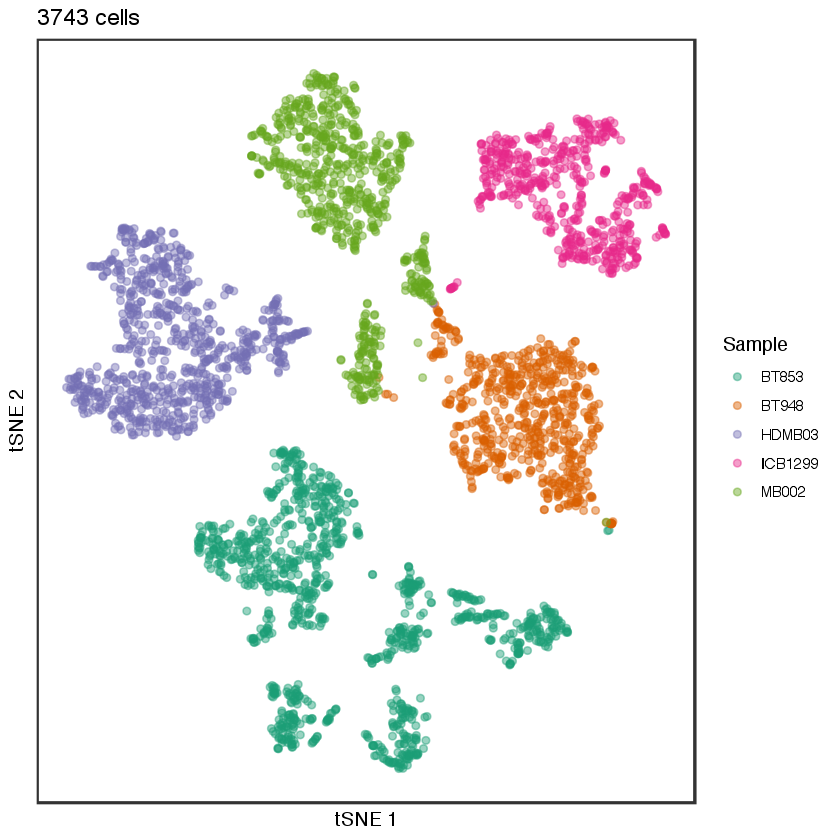

In [49]:
#colour by samlple

sp1 <- ggplot(test, aes(x=tSNE_1, y=tSNE_2, color=Sample)) + 
        geom_point(alpha = 0.45, size = 1.5) +  
        labs(x = "tSNE 1", y = "tSNE 2", title = "3743 cells") +
        scale_colour_brewer(palette = "Dark2") + 
        theme_bw() + 
        theme(axis.text.x = element_blank(), axis.text.y = element_blank(), axis.ticks = element_blank(),
              panel.border = element_rect(linetype = "solid", fill = NA, size = 1),
              panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
              panel.background = element_blank()) 

sp1

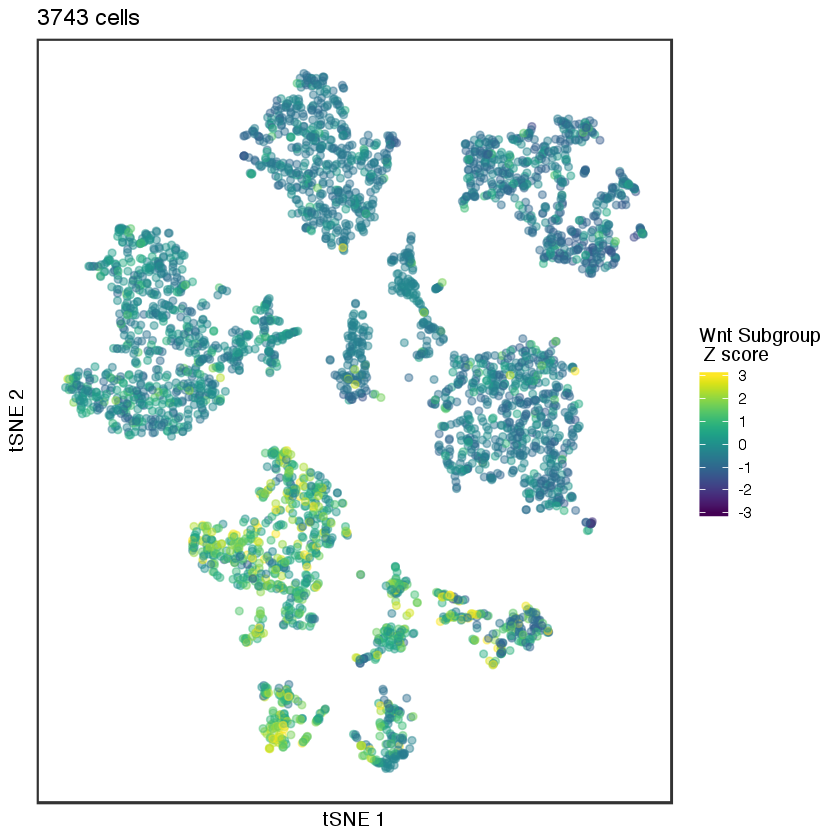

In [50]:
#colour by Wnt subgroup

#scale and z_score signatures

Wnt_z <- scale(test$Wnt, center = TRUE, scale = TRUE)

#cap scores at 3
Wnt_z[Wnt_z > 3] <- 3
Wnt_z[Wnt_z < (-3)] <- -3

sp2v <- ggplot(test, aes(x=tSNE_1, y=tSNE_2, color=Wnt_z)) + 
        geom_point(alpha = 0.45, size = 1.5) +  
        scale_color_viridis(option = "D",  limits=c(-3, 3), name = "Wnt Subgroup \n Z score") +
        labs(x = "tSNE 1", y = "tSNE 2", title = "3743 cells") +
        theme_bw() + 
        theme(axis.text.x = element_blank(), axis.text.y = element_blank(), axis.ticks = element_blank(),
              panel.border = element_rect(linetype = "solid", fill = NA, size = 1),
              panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
              panel.background = element_blank()) 

sp2v 

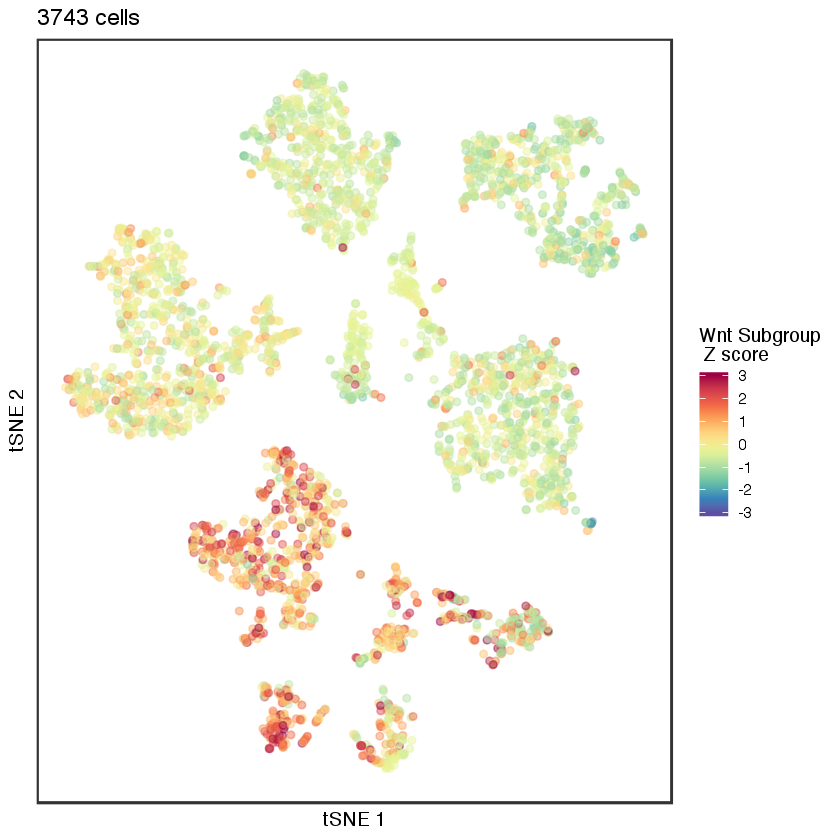

In [51]:
#colour by Wnt subgroup

#scale and z_score signatures

Wnt_z <- scale(test$Wnt, center = TRUE, scale = TRUE)

#cap scores at 3
Wnt_z[Wnt_z > 3] <- 3
Wnt_z[Wnt_z < (-3)] <- -3

sp2 <- ggplot(test, aes(x=tSNE_1, y=tSNE_2, color=Wnt_z)) + 
        geom_point(alpha = 0.45, size = 1.5) +  
         scale_colour_gradientn(colours = rev(brewer.pal(10, "Spectral")), limits = c(-3,3), name = "Wnt Subgroup \n Z score") +
        labs(x = "tSNE 1", y = "tSNE 2", title = "3743 cells") +
        theme_bw() + 
        theme(axis.text.x = element_blank(), axis.text.y = element_blank(), axis.ticks = element_blank(),
              panel.border = element_rect(linetype = "solid", fill = NA, size = 1),
              panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
              panel.background = element_blank()) 

sp2

In [52]:
#colur by Wnt activity
#scale and z_score signatures

Wnt_act_z <- scale(test$CANONICAL_WNT, center = TRUE, scale = TRUE)

#cap scores at 3
Wnt_act_z[Wnt_act_z > 3] <- 3
Wnt_act_z[Wnt_act_z < (-3)] <- -3


sp3v <- ggplot(test, aes(x=tSNE_1, y=tSNE_2, color=Wnt_act_z)) + 
        geom_point(alpha = 0.45, size = 1.5) +  
        scale_color_viridis(option = "D",  limits=c(-3, 3), name = "Canonical Wnt Pathway \n Z score") +
        labs(x = "tSNE 1", y = "tSNE 2", title = "3743 cells") +
        theme_bw() + 
        theme(axis.text.x = element_blank(), axis.text.y = element_blank(), axis.ticks = element_blank(),
              panel.border = element_rect(linetype = "solid", fill = NA, size = 1),
              panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
              panel.background = element_blank()) 

sp3 <- ggplot(test, aes(x=tSNE_1, y=tSNE_2, color=Wnt_act_z)) + 
        geom_point(alpha = 0.45, size = 1.5) +  
         scale_colour_gradientn(colours = rev(brewer.pal(10, "Spectral")), limits = c(-3,3), name = "Canonical Wnt Pathway \n Z score")+
        labs(x = "tSNE 1", y = "tSNE 2", title = "3743 cells") +
        theme_bw() + 
        theme(axis.text.x = element_blank(), axis.text.y = element_blank(), axis.ticks = element_blank(),
              panel.border = element_rect(linetype = "solid", fill = NA, size = 1),
              panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
              panel.background = element_blank()) 
 

In [53]:
# GROUP 3

group3_z <- scale(test$Group3, center = TRUE, scale = TRUE)

#cap scores at 3
group3_z[group3_z> 3] <- 3
group3_z[group3_z < (-3)] <- -3


sp5v <- ggplot(test, aes(x=tSNE_1, y=tSNE_2, color=group3_z)) + 
        geom_point(alpha = 0.45, size = 1.5) +  
        scale_color_viridis(option = "D",  limits=c(-3, 3), name = "Group 3 \n Z score") +
        labs(x = "tSNE 1", y = "tSNE 2", title = "3743 cells") +
        theme_bw() + 
        theme(axis.text.x = element_blank(), axis.text.y = element_blank(), axis.ticks = element_blank(),
              panel.border = element_rect(linetype = "solid", fill = NA, size = 1),
              panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
              panel.background = element_blank()) 

sp5 <- ggplot(test, aes(x=tSNE_1, y=tSNE_2, color=group3_z)) + 
        geom_point(alpha = 0.45, size = 1.5) +  
         scale_colour_gradientn(colours = rev(brewer.pal(10, "Spectral")), limits = c(-3,3), name = "Group3 \n Z score")+
        labs(x = "tSNE 1", y = "tSNE 2", title = "3743 cells") +
        theme_bw() + 
        theme(axis.text.x = element_blank(), axis.text.y = element_blank(), axis.ticks = element_blank(),
              panel.border = element_rect(linetype = "solid", fill = NA, size = 1),
              panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
              panel.background = element_blank()) 
 

In [54]:
# GROUP 4

group4_z <- scale(test$Group4, center = TRUE, scale = TRUE)

#cap scores at 3
group4_z[group4_z> 3] <- 3
group4_z[group4_z < (-3)] <- -3


sp6v <- ggplot(test, aes(x=tSNE_1, y=tSNE_2, color=group4_z)) + 
        geom_point(alpha = 0.45, size = 1.5) +  
        scale_color_viridis(option = "D",  limits=c(-3, 3), name = "Group 4 \n Z score") +
        labs(x = "tSNE 1", y = "tSNE 2", title = "3743 cells") +
        theme_bw() + 
        theme(axis.text.x = element_blank(), axis.text.y = element_blank(), axis.ticks = element_blank(),
              panel.border = element_rect(linetype = "solid", fill = NA, size = 1),
              panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
              panel.background = element_blank()) 

sp6 <- ggplot(test, aes(x=tSNE_1, y=tSNE_2, color=group4_z)) + 
        geom_point(alpha = 0.45, size = 1.5) +  
         scale_colour_gradientn(colours = rev(brewer.pal(10, "Spectral")), limits = c(-3,3), name = "Group4 \n Z score")+
        labs(x = "tSNE 1", y = "tSNE 2", title = "3743 cells") +
        theme_bw() + 
        theme(axis.text.x = element_blank(), axis.text.y = element_blank(), axis.ticks = element_blank(),
              panel.border = element_rect(linetype = "solid", fill = NA, size = 1),
              panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
              panel.background = element_blank()) 
 

In [55]:
pdf("~/Desktop/SinghWnt_June2018/SHH_REMOVED/Figure2_tSNEs.pdf")
sp1
sp2
sp3

sp5
sp6
dev.off()

pdf 
  2

In [56]:
pdf("~/Desktop/SinghWnt_June2018/SHH_REMOVED/Figure2_tSNEs_viridis.pdf")
sp1
sp2v
sp3v

sp5v
sp6v
dev.off()

pdf 
  2

---
# Plot QC metrics of filtered cells
---

[1] 14757.0 16531.0 18512.0 12503.5 11895.0

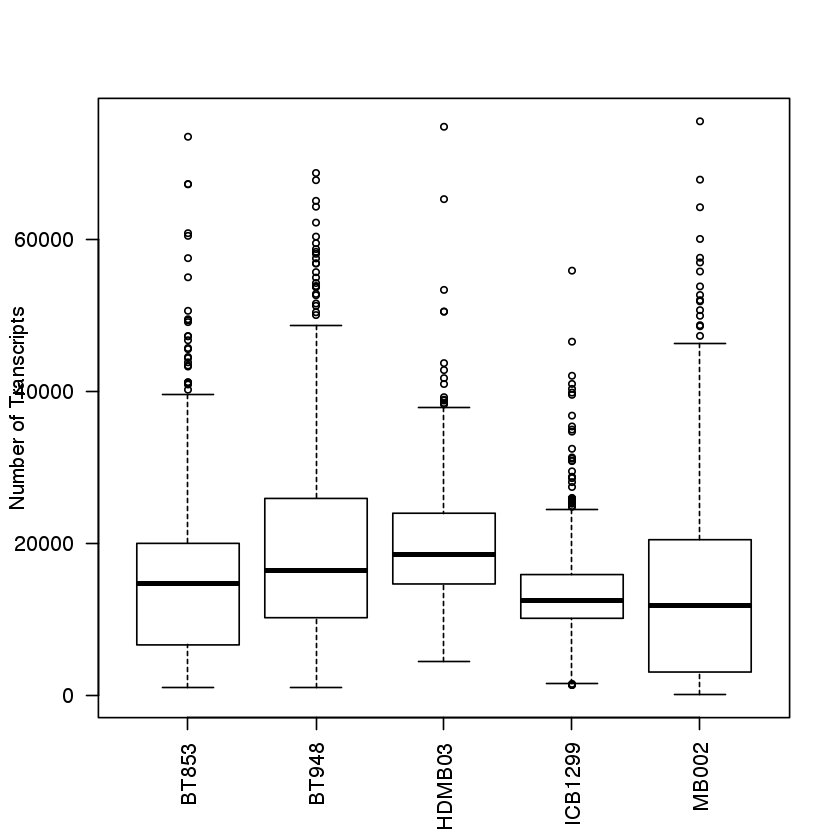

[1] 3780.5 3563.5 3235.0 2830.5 2440.0

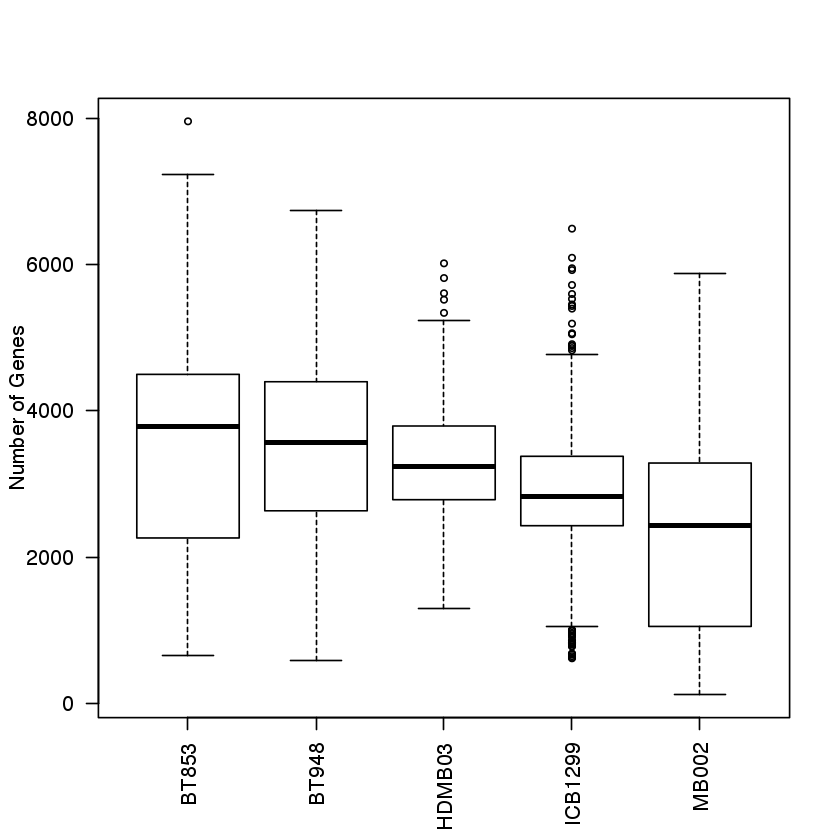

[1] 0.05035905 0.06921321 0.08350254 0.04363211 0.04115375

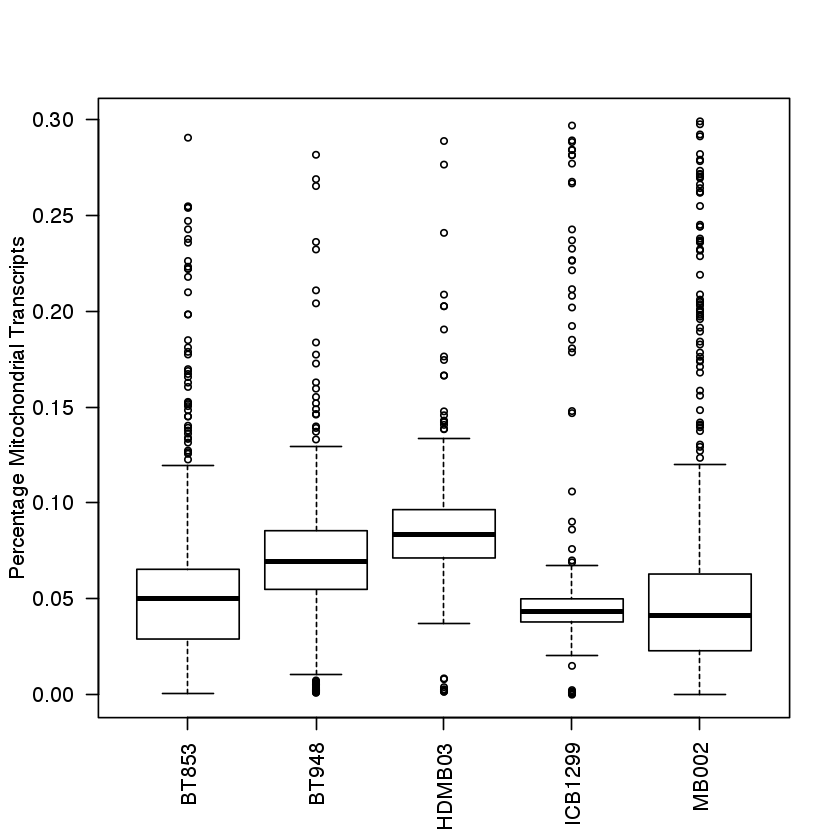

In [57]:
meta <- Wnt_medullo@meta.data

a <- boxplot(nUMI~Sample,
        data=meta,
        notch = F,
        ylab = "Number of Transcripts",
        las = 2,
        outcex= 0.6
)
a$stats[3,]

b <- boxplot(nGene~Sample,
        data=meta,
        notch = F,
        ylab = "Number of Genes",
        las = 2,
        outcex= 0.6
)
b$stats[3,]

c <- boxplot(percent.mito~Sample,
        data=meta,
        notch = F,
        ylab = "Percentage Mitochondrial Transcripts",
        las = 2,
        outcex= 0.6
)
c$stats[3,]

In [60]:
pdf("~/Desktop/SinghWnt_June2018/SHH_REMOVED/Figures/FiguresS4.pdf")

meta <- Wnt_medullo@meta.data

a <- boxplot(nUMI~Sample,
        data=meta,
        notch = F,
        ylab = "Number of Transcripts",
        las = 2,
        outcex= 0.6
)
a$stats[3,]

b <- boxplot(nGene~Sample,
        data=meta,
        notch = F,
        ylab = "Number of Genes",
        las = 2,
        outcex= 0.6
)
b$stats[3,]

c <- boxplot(percent.mito~Sample,
        data=meta,
        notch = F,
        ylab = "Percentage Mitochondrial Transcripts",
        las = 2,
        outcex= 0.6
)
c$stats[3,]


dev.off()

[1] 14757.0 16531.0 18512.0 12503.5 11895.0

[1] 3780.5 3563.5 3235.0 2830.5 2440.0

[1] 0.05035905 0.06921321 0.08350254 0.04363211 0.04115375

pdf 
  2

---
## Wnt subgroup heatmap
---

In [1]:
suppressMessages(library(pheatmap))
suppressMessages(library(RColorBrewer))
suppressMessages(library(viridis))
suppressMessages(library(scales))
suppressMessages(library(Seurat))

Warning message:
“package ‘pheatmap’ was built under R version 3.4.4”Warning message:
“package ‘viridis’ was built under R version 3.4.4”Warning message:
“package ‘viridisLite’ was built under R version 3.4.3”Warning message:
“package ‘Seurat’ was built under R version 3.4.4”Warning message:
“package ‘ggplot2’ was built under R version 3.4.4”Warning message:
“package ‘cowplot’ was built under R version 3.4.4”Warning message:
“package ‘Matrix’ was built under R version 3.4.4”

In [2]:
load("~/Desktop/Samwise/projects/BTSCs_scRNAseq/Wnt_medullo_noSHH.rdata")

In [5]:
sigs <- read.csv("~/Downloads/SinghWnt_SuppTables - Table S2. (2).csv", stringsAsFactors = F)
head(sigs)

WNT,SHH,GR_3,GR_4,KEGG_WNT,CANONICAL_WNT,WNT_ANNOTATIONS
EPHA7,DYRK1B,GNB3,ARHGEF12,APC,WNT1,Ligand
FZD10,ARRB2,GNGT1,RND1,APC2,WNT10A,Ligand
BMP4,GLI2,RCVRN,RHOT1,AXIN1,WNT16,Ligand
WNT16,GLI3,PDE6H,DPYSL4,AXIN2,WNT2,Ligand
EPHA4,HHIP,MYC,DIRAS3,BTRC,WNT2B,Ligand
NFATC4,GLI1,NLK,FNBP1,CACYBP,WNT3,Ligand


In [6]:
Wnt <- sigs[ ,1]
Wnt <- Wnt[Wnt != ""] 
Wnt <- gsub(" ", "", Wnt)#remove empty entries
Wnt

Wnt <- Wnt[(Wnt %in% row.names(Wnt_medullo@data))]
length(Wnt)


[1] "EPHA7"   "FZD10"   "BMP4"    "WNT16"   "EPHA4"   "NFATC4"  "SLIT2"  
 [8] "EPHA3"   "ADAM12"  "PRKCD"   "FZD6"    "ADAM19"  "PLCB1"   "SEMA3B" 
[15] "AXIN2"   "WIF1"    "DKK4"    "WNT16"   "DKK2"    "LEF1"    "KREMEN1"
[22] "DKK1"    "GLT8D2"  "GALNT7"  "GALNT14" "GALNT12" "GALNTL2"

In [8]:
# DEFINE GENE SIGNATURE SPECIFIC EXPRESSION MATRIX

#subset the normalzied expression matrix by gene sigs
#add Wnt signature score data to matrix

mat <- Wnt_medullo@data[rownames(Wnt_medullo@data) %in% Wnt, ]
dim(mat)
mat[1:5, 1:5]


[1]   23 3743

5 x 5 sparse Matrix of class "dgCMatrix"
        AAACCTGAGTCAATAG.1 AAACCTGGTCATTAGC.1 AAACCTGTCATTATCC.1
GALNT14                  .                  .                  .
EPHA4                    .                  .                  .
SEMA3B                   .                  .                  .
PRKCD                    .                  .                  .
EPHA3                    .                  .                  .
        AAACCTGTCTTACCGC.1 AAACGGGGTCACCCAG.1
GALNT14                  .                  .
EPHA4                    .                  .
SEMA3B                   .                  .
PRKCD                    .                  .
EPHA3                    .                  .

In [11]:
mat <- rbind(mat, 
             Wnt_medullo@meta.data$Wnt
            )
dim(mat)

row.names(mat)[24] <- c("Wnt_signature"
                           )

[1]   24 3743

In [14]:
BT853 <- mat[,(Wnt_medullo@meta.data$Sample == "BT853")]
col_order <- order(BT853[rownames(BT853) == "Wnt_signature",]) #order cells by Wnt signature
BT853 <- BT853[ ,col_order]

row_order <- c('Wnt_signature',
            Wnt
           )

mat_ordered <- BT853[match(row_order, rownames(BT853)),]
dim(mat_ordered)

In [18]:
samples <- c("HDMB03", "MB002", "BT948", "ICB1299")

for (i in 1:length(samples)){
    
    print(samples[i])
    df <- mat[,(Wnt_medullo@meta.data$Sample == samples[i])]
    col_order <- order(df[rownames(df) == "Wnt_signature",]) #order cells by Wnt signature
    df <- df[ ,col_order]

    row_order <- row_order <- c('Wnt_signature', Wnt)
    
    df <- df[match(row_order, rownames(df)),]
    print(dim(df))

    mat_ordered <- cbind(mat_ordered, df)
    
    
}

[1] "HDMB03"
[1]  25 795
[1] "MB002"
[1]  25 700
[1] "BT948"
[1]  25 642
[1] "ICB1299"
[1]  25 548


In [21]:
for (i in 1:nrow(mat_ordered)){ 
    
    mat_ordered[i,] <- scale(mat_ordered[i,]) #scale each row (z-score)
   
}

#crush the scale
mat_ordered[mat_ordered > 3] <- 3
mat_ordered[mat_ordered < (-3)] <- -3

In [22]:
breaks <- c(1058, 
            (1058+795),
            (1058+795+700),
            (1058+795+700+642),
            (1058+795+700+642+548)   
           )
breaks

breaksList <- seq(-3, 3, by = 0.25)

annotat <- Wnt_medullo@meta.data
#head(annotat)
mat_col <- annotat[ ,c(6:8)]
head(mat_col)

[1] 1058 1853 2553 3195 3743

,Sample,Subgroup,Stage
AAACCTGAGTCAATAG.1,BT853,WNT,Primary
AAACCTGGTCATTAGC.1,BT853,WNT,Primary
AAACCTGTCATTATCC.1,BT853,WNT,Primary
AAACCTGTCTTACCGC.1,BT853,WNT,Primary
AAACGGGGTCACCCAG.1,BT853,WNT,Primary
AAACGGGGTCTAGCGC.1,BT853,WNT,Primary


In [23]:
#Assign colours to the annotations

mat_colors <- list(Sample = brewer.pal(5, "Set1"),
                   
                   Subgroup = c("#a6611a",
                                "#80cdc1",
                                "#018571"
                                ),
                   
                   Stage = c("grey", "black")
                  )

names(mat_colors$Sample) <- unique(mat_col$Sample)
names(mat_colors$Subgroup) <- unique(mat_col$Subgroup)
names(mat_colors$Stage) <- unique(mat_col$Stage)
mat_colors

In [29]:
pheatmap(mat = mat_ordered,
         border_color = NA,
         color = colorRampPalette(rev(brewer.pal(n = 11, name = "RdBu")))(length(breaksList)),
         show_colnames = FALSE,
         show_rownames = TRUE,
         annotation_col = mat_col,
         annotation_colors = mat_colors,
         drop_levels = TRUE,
         fontsize = 10,
         main = "Wnt Subgroup",
         cluster_rows = FALSE,
         cluster_cols = FALSE,
         gaps_col = breaks,
         breaks = breaksList,
         annotation_names_row = FALSE,
         legend = TRUE,
         annotation_legend = TRUE,
         filename = "~/Desktop/SinghWnt_June2018/SHH_REMOVED/Wnt_subgroup_heatmap.pdf"
)

---
# REVISIONS
---

## Check cell counts

Reviewer is concerned that the cell counts in the heatmap in S5 and the tSNE do nt align. Reloaded by data and reviewd code above. They do align.


In [1]:
load("~/Desktop/Samwise/projects/BTSCs_scRNAseq/Wnt_medullo_noSHH.rdata")

In [3]:
table(Wnt_medullo@meta.data$Sample)


  BT853   BT948  HDMB03 ICB1299   MB002 
   1058     642     795     548     700 

## Z-scoring is misleading

Plot the raw scores to please reviewers.  

In [16]:
library(pheatmap)
library(RColorBrewer)

In [17]:
sigs <- read.csv("~/Downloads/SinghWnt_SuppTables - Table S2. (2).csv", stringsAsFactors = F)
head(sigs)

WNT,SHH,GR_3,GR_4,KEGG_WNT,CANONICAL_WNT,WNT_ANNOTATIONS
EPHA7,DYRK1B,GNB3,ARHGEF12,APC,WNT1,Ligand
FZD10,ARRB2,GNGT1,RND1,APC2,WNT10A,Ligand
BMP4,GLI2,RCVRN,RHOT1,AXIN1,WNT16,Ligand
WNT16,GLI3,PDE6H,DPYSL4,AXIN2,WNT2,Ligand
EPHA4,HHIP,MYC,DIRAS3,BTRC,WNT2B,Ligand
NFATC4,GLI1,NLK,FNBP1,CACYBP,WNT3,Ligand


In [18]:
Wnt <- sigs[ ,1]
Wnt <- Wnt[Wnt != ""] 
Wnt <- gsub(" ", "", Wnt)#remove empty entries
Wnt

Wnt <- Wnt[(Wnt %in% row.names(Wnt_medullo@data))]
length(Wnt)

[1] "EPHA7"   "FZD10"   "BMP4"    "WNT16"   "EPHA4"   "NFATC4"  "SLIT2"  
 [8] "EPHA3"   "ADAM12"  "PRKCD"   "FZD6"    "ADAM19"  "PLCB1"   "SEMA3B" 
[15] "AXIN2"   "WIF1"    "DKK4"    "WNT16"   "DKK2"    "LEF1"    "KREMEN1"
[22] "DKK1"    "GLT8D2"  "GALNT7"  "GALNT14" "GALNT12" "GALNTL2"

[1] 24

In [19]:
# DEFINE GENE SIGNATURE SPECIFIC EXPRESSION MATRIX

#subset the normalzied expression matrix by gene sigs
#add Wnt signature score data to matrix

mat <- Wnt_medullo@data[rownames(Wnt_medullo@data) %in% Wnt, ]
dim(mat)
mat[1:5, 1:5]

mat <- rbind(mat, 
             Wnt_medullo@meta.data$Wnt
            )
dim(mat)

row.names(mat)[24] <- c("Wnt_signature"
                           )

[1]   23 3743

5 x 5 sparse Matrix of class "dgCMatrix"
        AAACCTGAGTCAATAG.1 AAACCTGGTCATTAGC.1 AAACCTGTCATTATCC.1
GALNT14                  .                  .                  .
EPHA4                    .                  .                  .
SEMA3B                   .                  .                  .
PRKCD                    .                  .                  .
EPHA3                    .                  .                  .
        AAACCTGTCTTACCGC.1 AAACGGGGTCACCCAG.1
GALNT14                  .                  .
EPHA4                    .                  .
SEMA3B                   .                  .
PRKCD                    .                  .
EPHA3                    .                  .

[1]   24 3743

In [20]:
BT853 <- mat[,(Wnt_medullo@meta.data$Sample == "BT853")]
col_order <- order(BT853[rownames(BT853) == "Wnt_signature",]) #order cells by Wnt signature
BT853 <- BT853[ ,col_order]

row_order <- c('Wnt_signature',
            Wnt
           )

mat_ordered <- BT853[match(row_order, rownames(BT853)),]
dim(mat_ordered)

[1]   25 1058

In [21]:
samples <- c("HDMB03", "MB002", "BT948", "ICB1299")

for (i in 1:length(samples)){
    
    print(samples[i])
    df <- mat[,(Wnt_medullo@meta.data$Sample == samples[i])]
    col_order <- order(df[rownames(df) == "Wnt_signature",]) #order cells by Wnt signature
    df <- df[ ,col_order]

    row_order <- row_order <- c('Wnt_signature', Wnt)
    
    df <- df[match(row_order, rownames(df)),]
    print(dim(df))

    mat_ordered <- cbind(mat_ordered, df)
    
    
}

[1] "HDMB03"
[1]  25 795
[1] "MB002"
[1]  25 700
[1] "BT948"
[1]  25 642
[1] "ICB1299"
[1]  25 548


In [22]:
##### DO NOT ZSCORE THE DATA


#for (i in 1:nrow(mat_ordered)){ 
    
#    mat_ordered[i,] <- scale(mat_ordered[i,]) #scale each row (z-score)
   
#}

#crush the scale
#mat_ordered[mat_ordered > 3] <- 3
#mat_ordered[mat_ordered < (-3)] <- -3


In [46]:
breaks <- c(1058, 
            (1058+795),
            (1058+795+700),
            (1058+795+700+642),
            (1058+795+700+642+548)   
           )
breaks

breaksList <- seq(-6, 6, by = 0.25)

annotat <- Wnt_medullo@meta.data
#head(annotat)
mat_col <- annotat[ ,c(6:8)]
head(mat_col)

[1] 1058 1853 2553 3195 3743

,Sample,Subgroup,Stage
AAACCTGAGTCAATAG.1,BT853,WNT,Primary
AAACCTGGTCATTAGC.1,BT853,WNT,Primary
AAACCTGTCATTATCC.1,BT853,WNT,Primary
AAACCTGTCTTACCGC.1,BT853,WNT,Primary
AAACGGGGTCACCCAG.1,BT853,WNT,Primary
AAACGGGGTCTAGCGC.1,BT853,WNT,Primary


In [47]:
#Assign colours to the annotations

mat_colors <- list(Sample = brewer.pal(5, "Set1"),
                   
                   Subgroup = c("#a6611a",
                                "#80cdc1",
                                "#018571"
                                ),
                   
                   Stage = c("grey", "black")
                  )

names(mat_colors$Sample) <- unique(mat_col$Sample)
names(mat_colors$Subgroup) <- unique(mat_col$Subgroup)
names(mat_colors$Stage) <- unique(mat_col$Stage)
mat_colors

$Sample
    BT853     BT948    HDMB03   ICB1299     MB002 
"#E41A1C" "#377EB8" "#4DAF4A" "#984EA3" "#FF7F00" 

$Subgroup
      WNT      GR_4      GR_3 
"#a6611a" "#80cdc1" "#018571" 

$Stage
  Primary Recurrent 
   "grey"   "black"

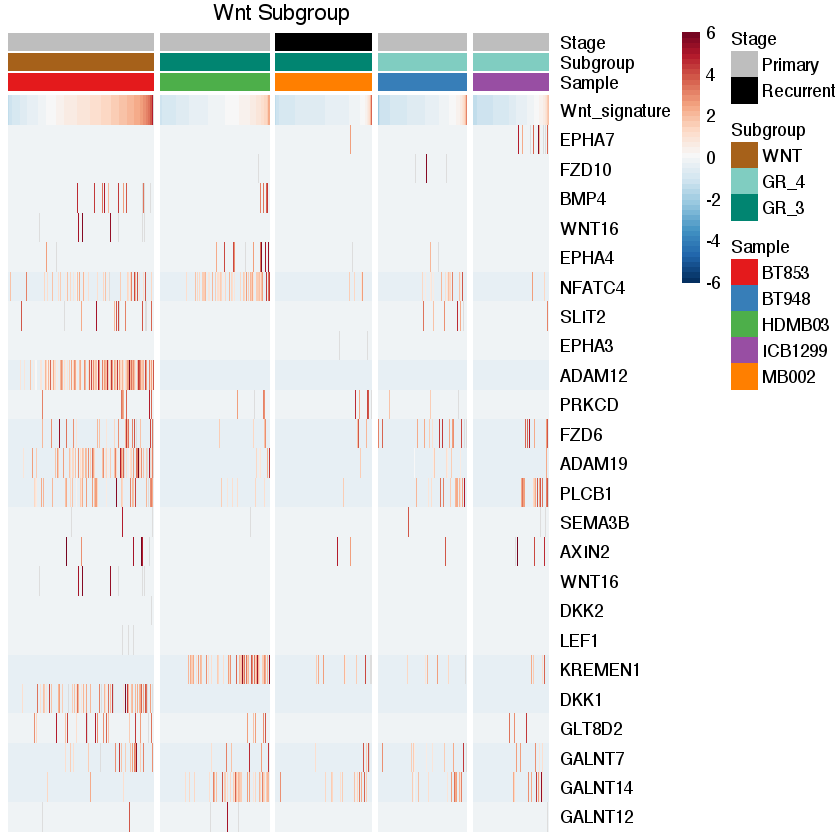

In [48]:
pheatmap(mat = mat_ordered_z,
         border_color = NA,
         color = colorRampPalette(rev(brewer.pal(n = 11, name = "RdBu")))(length(breaksList)),
         show_colnames = FALSE,
         show_rownames = TRUE,
         annotation_col = mat_col,
         annotation_colors = mat_colors,
         drop_levels = TRUE,
         fontsize = 10,
         main = "Wnt Subgroup",
         cluster_rows = FALSE,
         cluster_cols = FALSE,
         gaps_col = breaks,
         breaks = breaksList,
         annotation_names_row = FALSE,
         legend = TRUE,
         annotation_legend = TRUE,
         #filename = "~/Desktop/SinghWnt_June2018/SHH_REMOVED/Wnt_subgroup_heatmap.pdf"
)

----

In [38]:
mat_ordered_z <- mat_ordered

for (i in 1:nrow(mat_ordered_z)){ 
    
    mat_ordered_z[i,] <- scale(mat_ordered_z[i,]) #scale each row (z-score)
   
}

#crush the scale
#mat_ordered_z[mat_ordered_z > 3] <- 3
#mat_ordered_z[mat_ordered_z < (-3)] <- -3


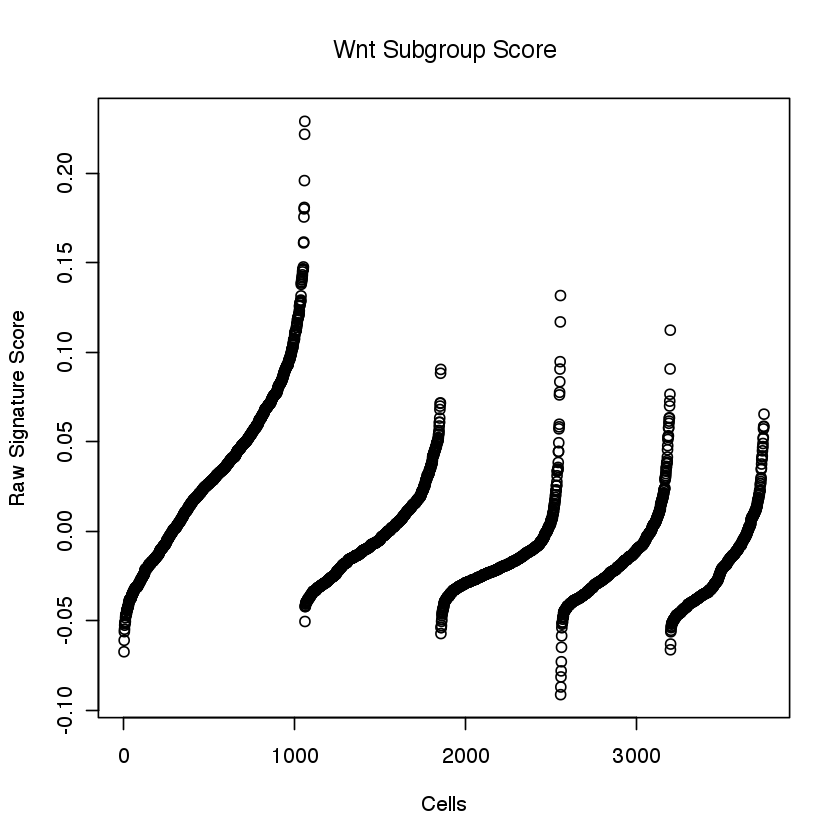

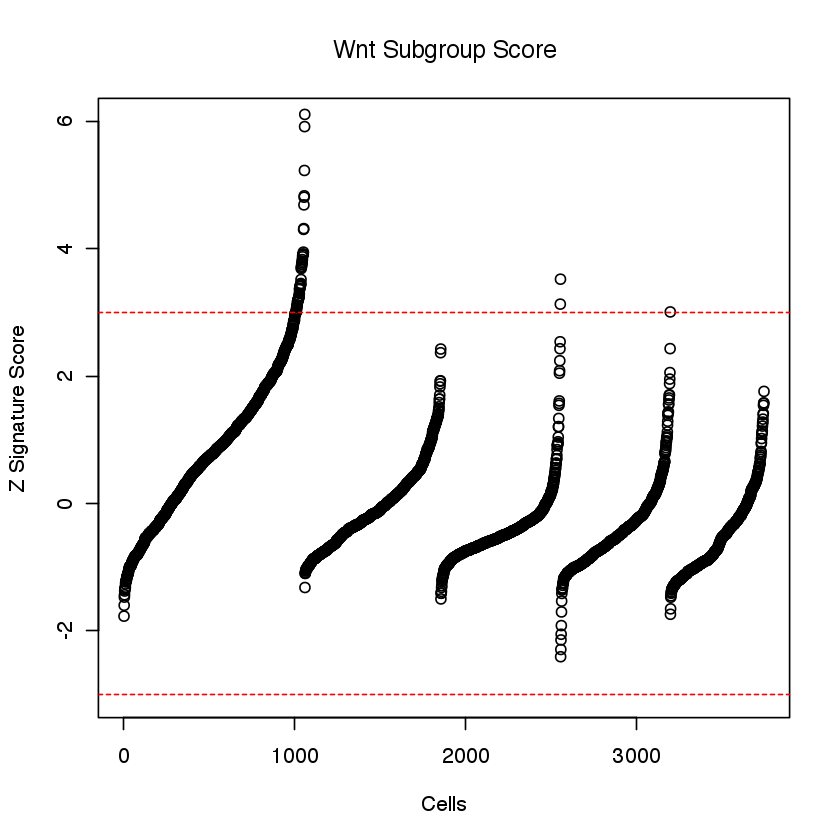

In [51]:
plot(mat_ordered[1,],
     main = "Wnt Subgroup Score",
     xlab = "Cells",
     ylab = "Raw Signature Score"
    )


plot(mat_ordered_z[1,],
     main = "Wnt Subgroup Score",
     xlab = "Cells",
     ylab = "Z Signature Score",
     ylim = c(-3,6)
    )
abline(h=c(-3,3), lty = 2, col = "red")

---
## GSVA Scoring

https://bioconductor.org/packages/devel/bioc/vignettes/GSVA/inst/doc/GSVA.pdf

In [60]:
#source("https://bioconductor.org/biocLite.R")
#biocLite("GSVA")

library(GSVA)

In [ ]:
gbm_es <- gsva(as.matrix(Wnt_medullo@data), 
               list(Wnt), 
               method = "gsva",
               rnaseq = FALSE, #we are using normalized data
               mx.diff=FALSE, 
               verbose = TRUE, 
               parallel.sz=1
              )